In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
#train_loader, valid_loader, test_loader = mnist(valid=10000, transform=transforms.ToTensor())
path='./MNIST_data'

mnist_data = datasets.MNIST(path, download=True, transform=transforms.ToTensor()).train_data.float()
train_mean = mnist_data.mean() / 255
train_std = mnist_data.std() / 255

mnist_sigm = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((train_mean,), (train_std,)),
                lambda x: x.to(device)
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_sigm)

In [5]:
train_data = datasets.MNIST('./MNIST_data', download=True, transform=mnist_sigm)
im = [train_data[i][0] for i in range(len(mnist_data))]
trdata = torch.stack(im).float()
print ("Transformed data mean: {:.8}".format(trdata.mean()))
print ("Transformed data std: {:.8}".format(trdata.std()))

Transformed data mean: -1.9292506e-07
Transformed data std: 1.0


In [6]:
def get_random_h():
    z = torch.randn((50, 4))     
    return z

In [7]:
train_epoch = 200
batch_size = 50
test_reveal_period = 20
batch_zeros = torch.zeros((batch_size, 1)).to(device)
batch_ones = torch.ones((batch_size, 1)).to(device)

In [8]:
fixed_data, _ = next(iter(test_loader))
fixed_data = fixed_data.to(device)
fixed_h = get_random_h().to(device)

In [9]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.LeakyReLU(0.1), stride=1, device='cpu'):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
        self.to(device)
    
    def forward(self, x):
        return self.model(x)

In [10]:
class DeconvLayer(nn.Module):
    def __init__(self, size, padding=1, stride=1, 
                 bn=False, dropout=False, activation_fn=nn.LeakyReLU(0.1), output_padding=0, device='cpu'):
        super(DeconvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding, 
                                         stride=stride, output_padding=output_padding))
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
        self.to(device)
    
    def forward(self, x):
        return self.model(x)

In [11]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Sigmoid(), flatten=False, last_fn=None, device='cpu'):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        self.to(device)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [12]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, optim_type='SGD', device='cpu', **optim_params):
        super(Net, self).__init__()
        
        self.latent_size = 4
        
        self._conv1 = ConvLayer([1, 16, 4], padding=0, bn=batchnorm, dropout=dropout, stride=2, pool_layer=None, device=device)
        self._conv2 = ConvLayer([16, 32, 4], padding=0, bn=batchnorm, dropout=dropout, stride=2, pool_layer=None, device=device)
        self._conv3 = ConvLayer([32, 32, 3], padding=0, bn=batchnorm, dropout=dropout, stride=2, pool_layer=None, device=device)
        
        self.latent_fn = nn.Sigmoid()
                    
        self.fce = FullyConnected([32*2*2, self.latent_size])
        self.fcd = FullyConnected([self.latent_size, 32*2*2])
        
        self._deconv1 = DeconvLayer([32, 32, 3], stride=2, padding=0, bn=batchnorm, device=device)
        self._deconv2 = DeconvLayer([32, 16, 4], stride=2, padding=0, bn=batchnorm, output_padding=1, device=device)
        self._deconv3 = DeconvLayer([16, 1, 4], stride=2, padding=0, bn=batchnorm, activation_fn=nn.Sigmoid(), device=device)
    
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
                    
        self.discr = FullyConnected([self.latent_size, 256, 256, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), flatten=True, device=device)       
        self.d_optimizer = optim.Adam(self.discr.parameters(), **optim_params)
        
        self.to(device)
        
       
    def conv(self, x):
        l1 = self._conv1(x)
        l2 = self._conv2(l1)
        l3 = self._conv3(l2)
        return l3, l2, l1
    
    def encode(self, x):
        l3 = self.conv(x)[0]
        flatten = l3.view(-1, 32*2*2)
        h = self.latent_fn(self.fce(flatten))
        return h
    
    def decode(self, h):
        flatten = self.fcd(h)
        l1 = flatten.view(-1, 32, 2, 2)
        l2 = self._deconv1(l1)
        l3 = self._deconv2(l2)
        x = self._deconv3(l3)
        return x
    
    def discriminator(self, x):        
        x = self.discr(x)       
        return x
                
    def forward(self, x):
        self.h = self.encode(x)
        x = self.decode(self.h)
        return x
    
    def ae_loss(self, data):
                       
        output = self.forward(data)     
        self._reconst_loss = F.mse_loss(output, data) 
        
        encoded = self.encode(data) 
        fake_pred = self.discriminator(encoded) 
        self._discr_loss = 0.1 * F.binary_cross_entropy_with_logits(fake_pred, batch_ones)        
        
        self._ae_loss = self._reconst_loss + self._discr_loss
                        
        return self._ae_loss
    
    def ds_loss(self, data):
                       
        encoded = self.encode(data)           
        fake_pred = self.discriminator(encoded)
        true_pred = self.discriminator(get_random_h().to(device))

        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones) 
        self._ds_loss = 0.5*(fake_loss + true_loss)
        
        return self._ds_loss

In [13]:
models = {
    'Adam Discr+bn': Net(True, False, optim_type='Adam', lr=1e-4, device=device),
   # 'Adam Discr+dp': Net(False, True, optim_type='Adam', lr=1e-4, device=device),
    'Adam Discr+bn+dp': Net(True, True, optim_type='Adam', lr=1e-4, device=device),
}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [14]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        for model in models.values():
            
            # train discriminator
            model.optim.zero_grad()
            model.d_optimizer.zero_grad()
                     
            ds_loss = model.ds_loss(data)        
            ds_loss.backward()
            model.d_optimizer.step()
                        
            # train AE
            model.optim.zero_grad()
            model.d_optimizer.zero_grad()
                      
            ae_loss = model.ae_loss(data)            
            ae_loss.backward()
            model.optim.step()
                       
            
        if batch_idx % 500 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: AE:{:.4f} D:{:.4f}'.format(k, m._ae_loss.item(), m._ds_loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: AE:{:.4f} D:{:.4f}'.format(k, m._ae_loss.item(), m._ds_loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._ae_loss, models[k]._ds_loss))
        print(line + losses)

In [15]:
def plot_latent(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))

    plt.show()
    

In [16]:
def test(models, loader, epoch, period, log=None):
    test_size = len(loader)
    test_rc_loss = {k: 0. for k in models}
    test_ds_loss = {k: 0. for k in models}
    test_discr_loss = {k: 0. for k in models}
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(train_loader):
            output = {k: m.forward(data) for k, m in models.items()}
            for k, m in models.items():                
                m.ae_loss(data)
                test_rc_loss[k] += m._reconst_loss
                test_discr_loss[k] += m._discr_loss
                test_ds_loss[k] += m.ds_loss(data).item() 
    
    for k in models:
        test_rc_loss[k] /= test_size
        test_discr_loss[k] /= test_size 
        test_ds_loss[k] /= test_size 
    report = 'Test losses: \n' + ''.join(['{}: {:.8f} / {:.8f} / {:.8f} \n'.format(k, test_rc_loss[k], 
                                         test_discr_loss[k], test_ds_loss[k]) 
                                         for k in models])
    if log is not None:
        for k in models:
            log[k].append((test_rc_loss[k], test_discr_loss[k], test_ds_loss[k],))
            if epoch % period == 0:
                with torch.no_grad():
                    print ("Model {}:".format(k))
                    ae_data = models[k].forward(fixed_data).clamp(0, 1).cpu().data.numpy()
                    fixed_gen = models[k].decode(fixed_h).clamp(0, 1).cpu().data.numpy()
                    random_gen = models[k].decode(get_random_h().to(device)).clamp(0, 1).cpu().data.numpy()
                    plot_mnist(ae_data, (5, 10))
                    plot_mnist(fixed_gen, (5, 10)) 
                    plot_mnist(random_gen, (5, 10)) 

                    encoded = model.encode(fixed_data[:10])
                    enc_to_lot = encoded.view(-1, 1, 2, 2).clamp(0, 1).cpu().data.numpy()
                    plot_latent(enc_to_lot, (1, 10))
            
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.3143 D:0.6833 Adam Discr+dp: AE:1.3122 D:0.6977 Adam Discr+bn+dp: AE:1.3454 D:0.7008
Train Epoch: 1 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.3122 D:0.1463 Adam Discr+dp: AE:1.1727 D:0.1213 Adam Discr+bn+dp: AE:1.3280 D:0.0695
Train Epoch: 1 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.2975 D:0.2161 Adam Discr+dp: AE:1.0960 D:0.3565 Adam Discr+bn+dp: AE:1.3614 D:0.0544
Test losses: 
Adam Discr+bn: 5.29564619 / 1.39774871 / 0.68683066 
Adam Discr+dp: 4.47246218 / 1.42837203 / 1.00478355 
Adam Discr+bn+dp: 5.27324820 / 1.65350294 / 0.34272089 

Train Epoch: 2 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.3271 D:0.1310 Adam Discr+dp: AE:1.0783 D:0.3500 Adam Discr+bn+dp: AE:1.3578 D:0.1212
Train Epoch: 2 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.2935 D:0.2500 Adam Discr+dp: AE:1.0899 D:0.2557 Adam Discr+bn+dp: AE:1.3573 D:0.1095
Train Epoch: 2 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.2852 D:0.1897 Adam Discr+dp: AE:1.

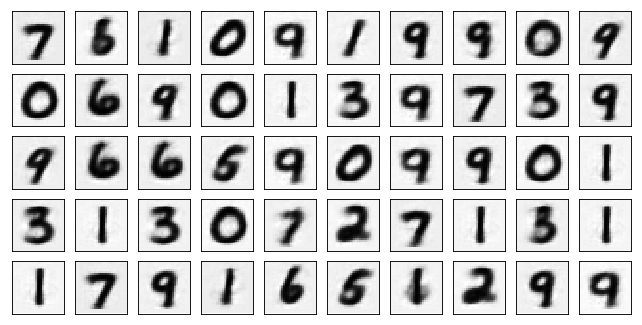

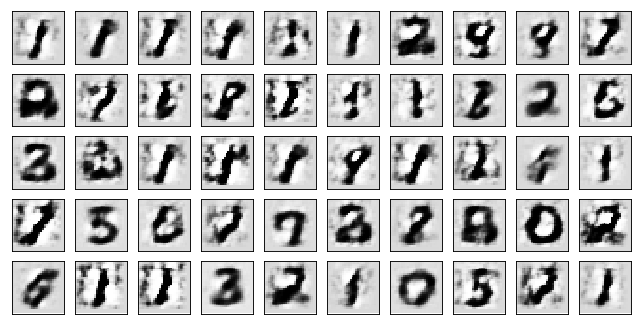

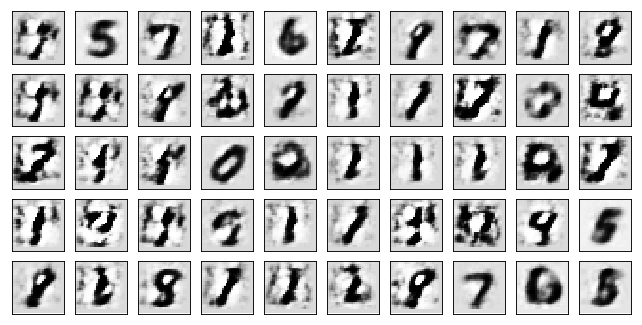

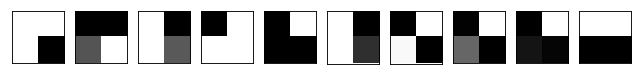

Model Adam Discr+dp:


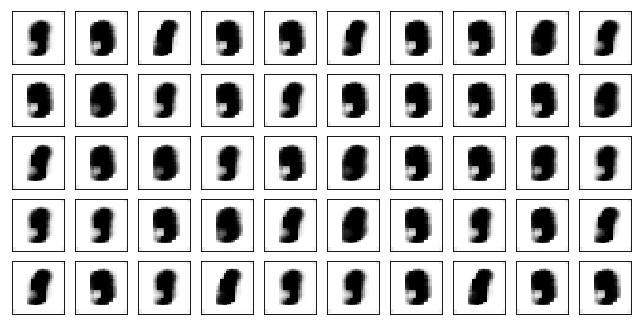

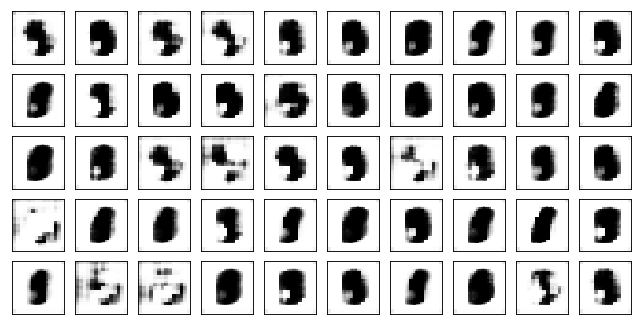

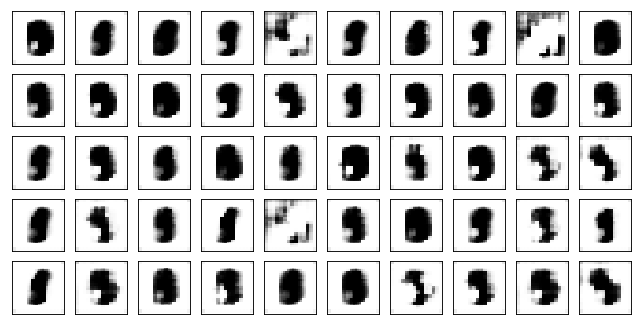

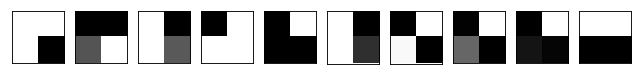

Model Adam Discr+bn+dp:


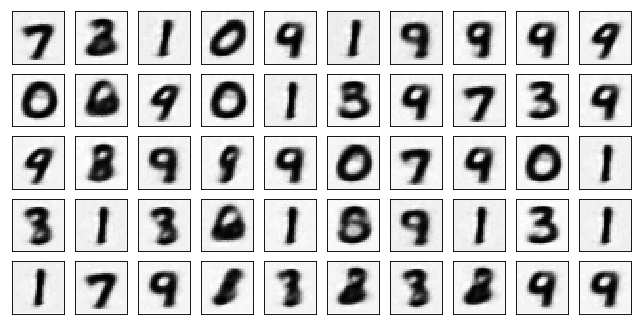

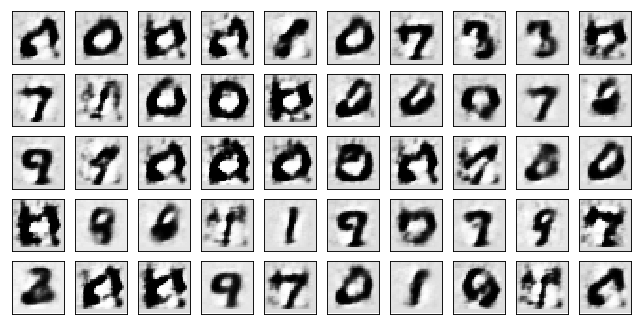

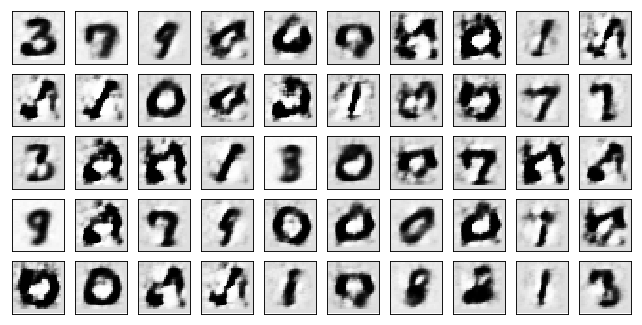

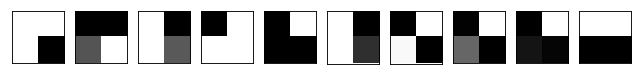

Test losses: 
Adam Discr+bn: 3.93100405 / 1.52629304 / 0.58885991 
Adam Discr+dp: 3.89771175 / 1.38670945 / 0.60754454 
Adam Discr+bn+dp: 3.93315935 / 1.44406068 / 0.61084720 

Train Epoch: 11 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.0593 D:0.1605 Adam Discr+dp: AE:1.0364 D:0.1367 Adam Discr+bn+dp: AE:1.0479 D:0.1844
Train Epoch: 11 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.0034 D:0.1887 Adam Discr+dp: AE:1.0512 D:0.1606 Adam Discr+bn+dp: AE:1.0371 D:0.1544
Train Epoch: 11 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.0604 D:0.1042 Adam Discr+dp: AE:1.0766 D:0.0734 Adam Discr+bn+dp: AE:1.0742 D:0.1838
Test losses: 
Adam Discr+bn: 3.84830976 / 1.57297242 / 0.54963015 
Adam Discr+dp: 3.87291884 / 1.55422401 / 0.59184420 
Adam Discr+bn+dp: 3.87127614 / 1.53100765 / 0.59220471 

Train Epoch: 12 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.0523 D:0.0945 Adam Discr+dp: AE:1.0608 D:0.1863 Adam Discr+bn+dp: AE:1.0294 D:0.2841
Train Epoch: 12 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.

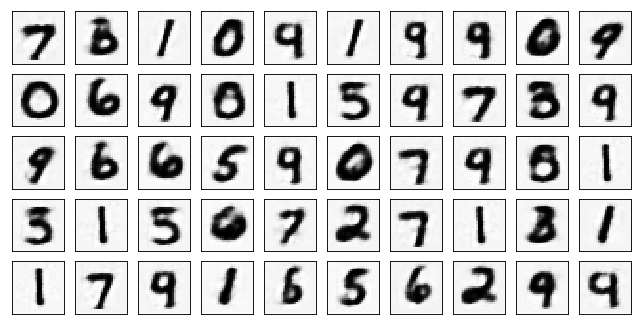

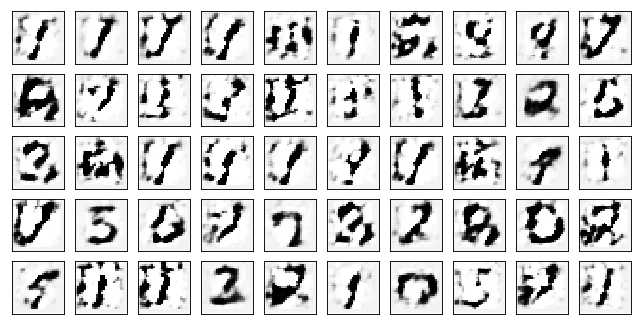

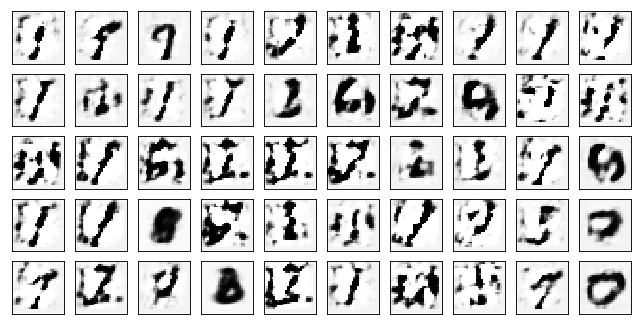

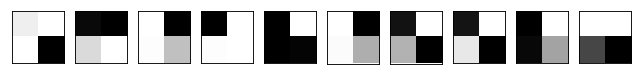

Model Adam Discr+dp:


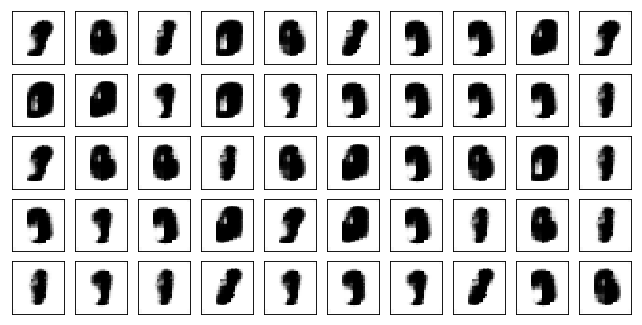

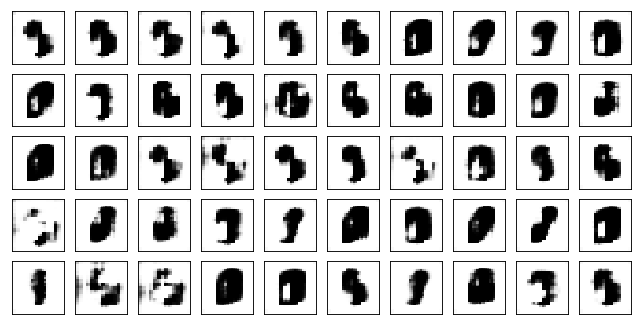

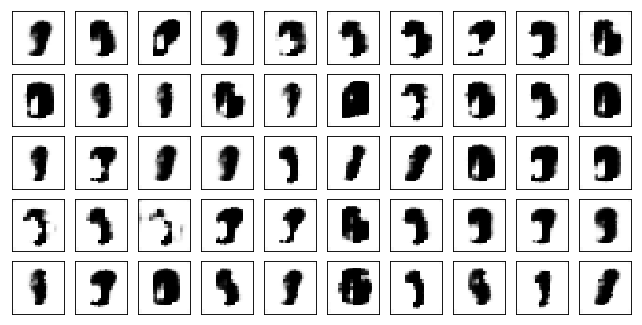

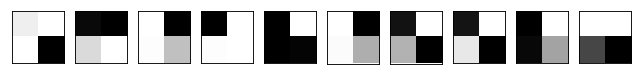

Model Adam Discr+bn+dp:


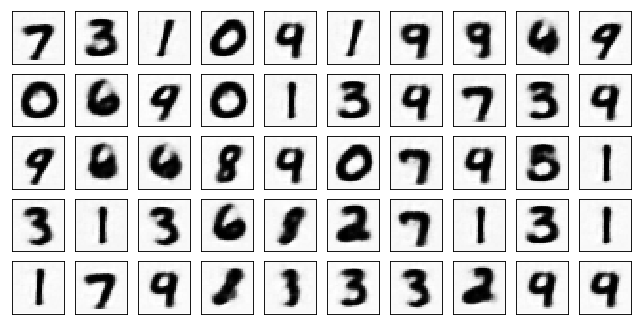

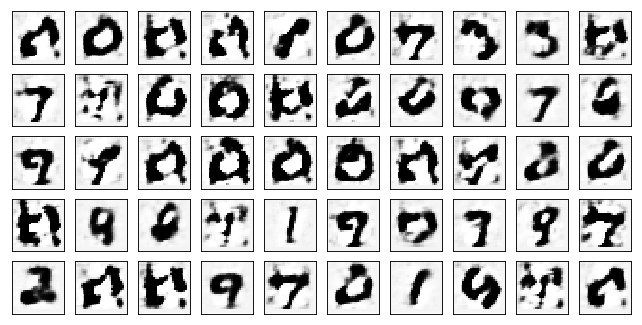

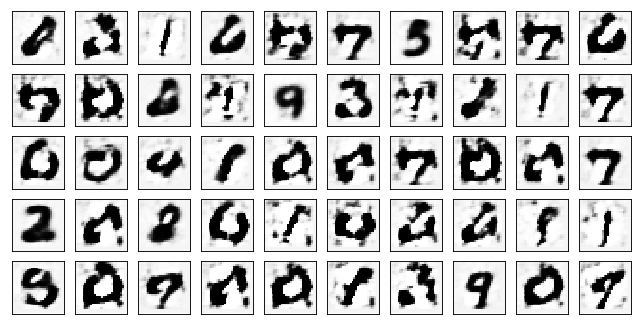

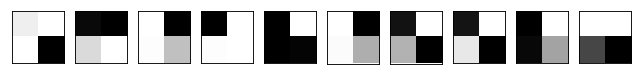

Test losses: 
Adam Discr+bn: 3.33949423 / 1.75573027 / 0.38464236 
Adam Discr+dp: 3.74768281 / 1.94416773 / 0.28185642 
Adam Discr+bn+dp: 3.43887925 / 1.82266212 / 0.35775432 

Train Epoch: 21 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.0148 D:0.0960 Adam Discr+dp: AE:1.1123 D:0.0877 Adam Discr+bn+dp: AE:1.0889 D:0.0856
Train Epoch: 21 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:0.9976 D:0.0919 Adam Discr+dp: AE:1.1158 D:0.0648 Adam Discr+bn+dp: AE:1.0417 D:0.1010
Train Epoch: 21 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:0.9644 D:0.0565 Adam Discr+dp: AE:1.0942 D:0.0359 Adam Discr+bn+dp: AE:1.0179 D:0.0662
Test losses: 
Adam Discr+bn: 3.31243825 / 1.78585517 / 0.39023999 
Adam Discr+dp: 3.73125792 / 2.15008903 / 0.28327324 
Adam Discr+bn+dp: 3.39907742 / 1.96621323 / 0.36232842 

Train Epoch: 22 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.0278 D:0.0904 Adam Discr+dp: AE:1.1766 D:0.0387 Adam Discr+bn+dp: AE:1.0748 D:0.0948
Train Epoch: 22 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.

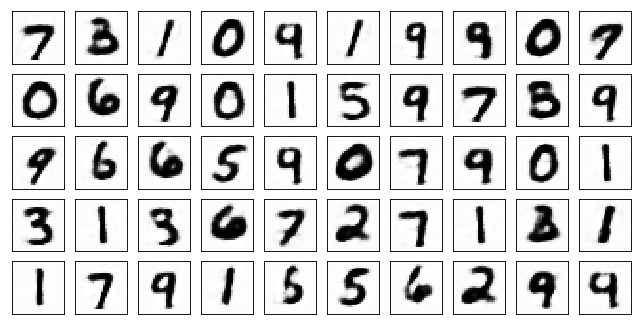

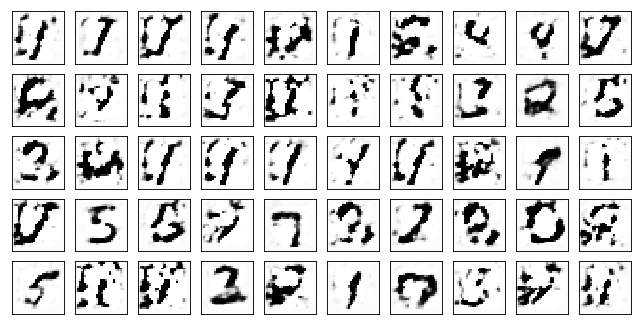

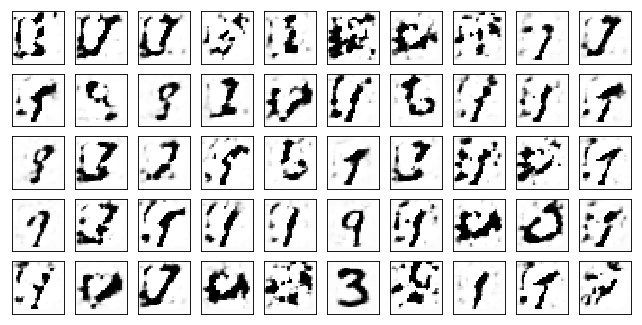

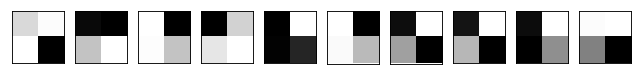

Model Adam Discr+dp:


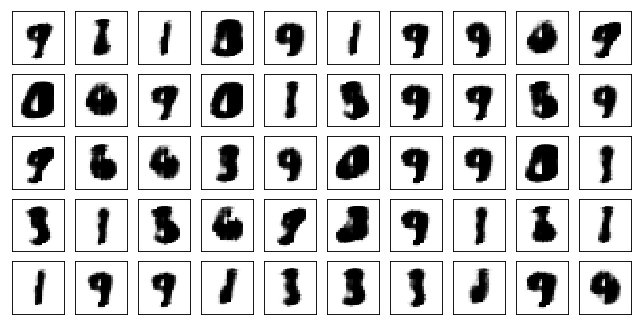

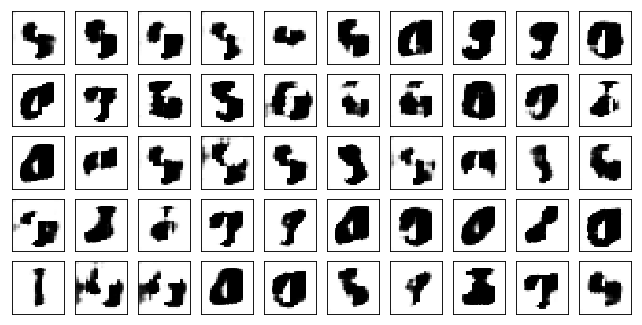

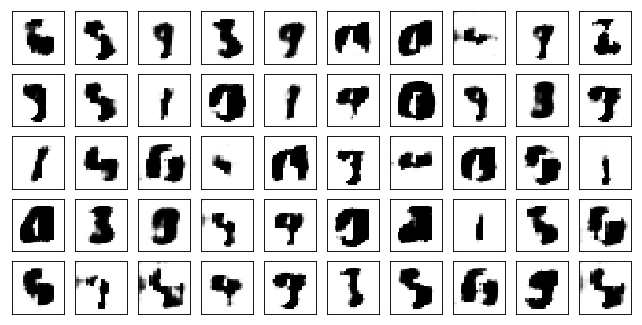

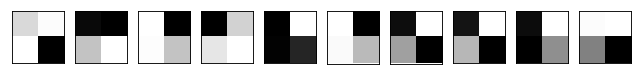

Model Adam Discr+bn+dp:


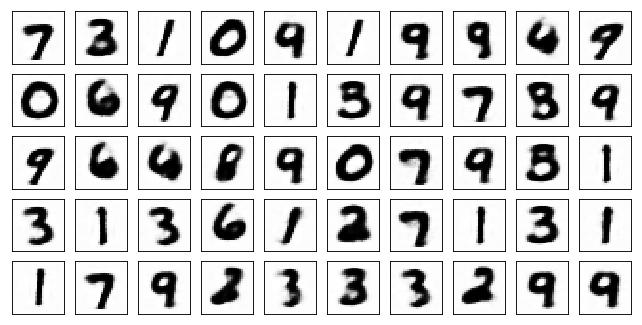

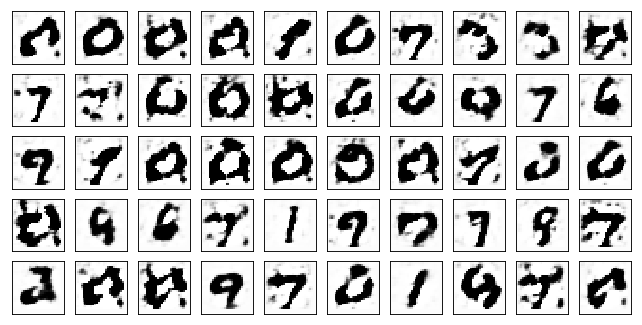

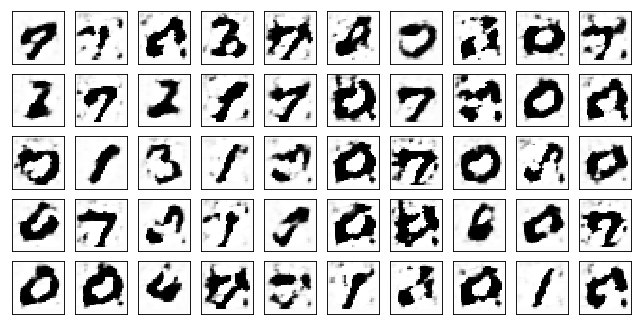

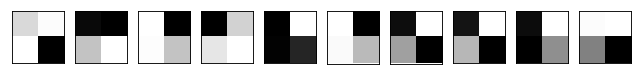

Test losses: 
Adam Discr+bn: 3.15786958 / 1.80352688 / 0.34749572 
Adam Discr+dp: 3.42486930 / 1.93627000 / 0.32456820 
Adam Discr+bn+dp: 3.25393271 / 1.97217155 / 0.32982281 

Train Epoch: 31 [0/50000 (0%)]	Losses Adam Discr+bn: AE:0.9612 D:0.1209 Adam Discr+dp: AE:1.0536 D:0.0563 Adam Discr+bn+dp: AE:1.0076 D:0.0679
Train Epoch: 31 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:0.9684 D:0.0522 Adam Discr+dp: AE:1.0604 D:0.1295 Adam Discr+bn+dp: AE:1.0062 D:0.0959
Train Epoch: 31 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:0.9748 D:0.0522 Adam Discr+dp: AE:1.0335 D:0.0677 Adam Discr+bn+dp: AE:1.0115 D:0.0828
Test losses: 
Adam Discr+bn: 3.14641285 / 1.89813197 / 0.36258212 
Adam Discr+dp: 3.39968967 / 1.88476813 / 0.30452232 
Adam Discr+bn+dp: 3.24619770 / 2.00977039 / 0.32532067 

Train Epoch: 32 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.0202 D:0.1230 Adam Discr+dp: AE:1.0995 D:0.1426 Adam Discr+bn+dp: AE:1.0651 D:0.0542
Train Epoch: 32 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:0.

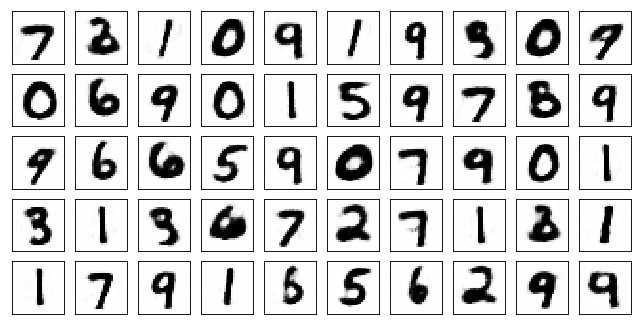

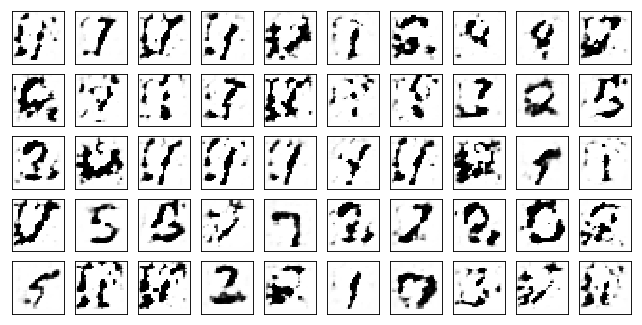

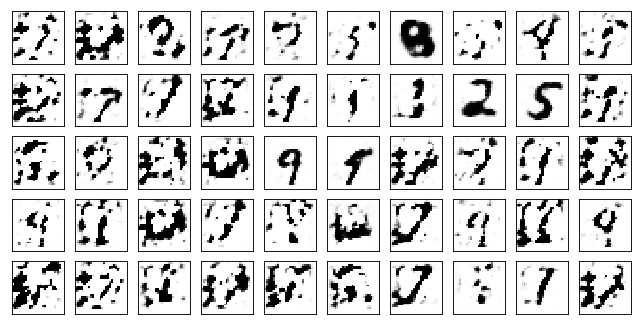

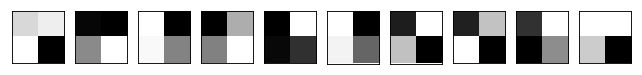

Model Adam Discr+dp:


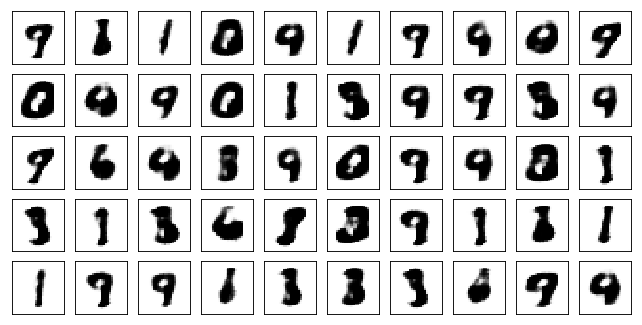

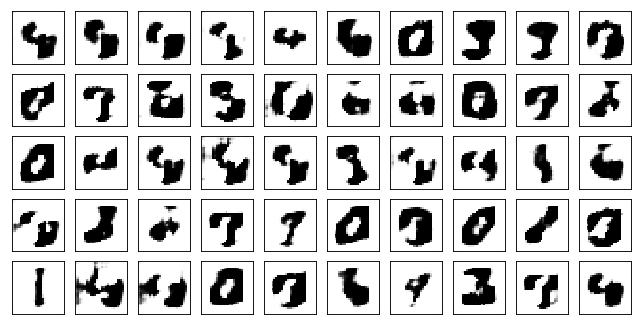

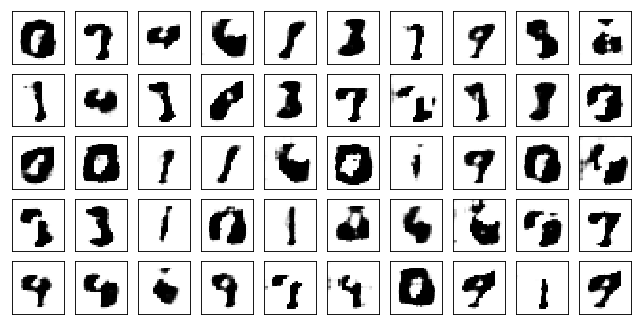

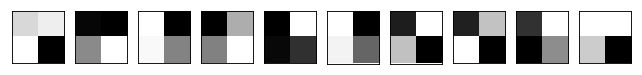

Model Adam Discr+bn+dp:


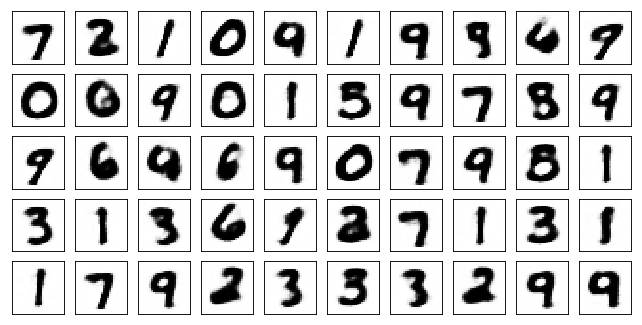

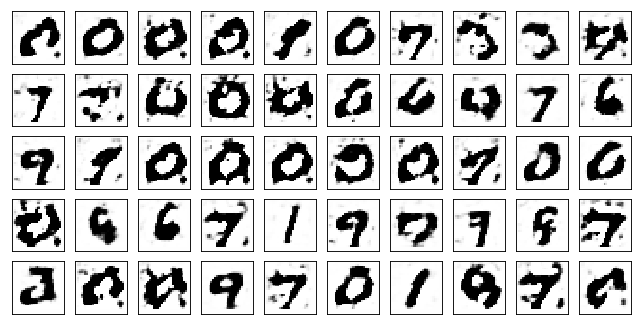

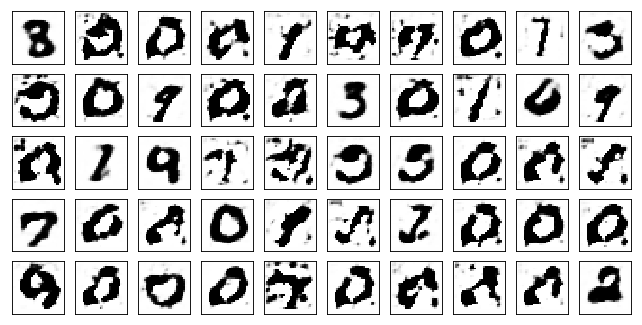

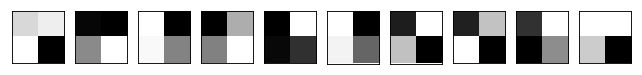

Test losses: 
Adam Discr+bn: 3.08671117 / 1.85142660 / 0.31794863 
Adam Discr+dp: 3.31896091 / 1.90080929 / 0.29182397 
Adam Discr+bn+dp: 3.19916749 / 1.92763376 / 0.30069193 

Train Epoch: 41 [0/50000 (0%)]	Losses Adam Discr+bn: AE:0.9586 D:0.0676 Adam Discr+dp: AE:1.0385 D:0.0747 Adam Discr+bn+dp: AE:1.0294 D:0.0946
Train Epoch: 41 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:0.9902 D:0.0856 Adam Discr+dp: AE:1.0579 D:0.0783 Adam Discr+bn+dp: AE:1.0398 D:0.0901
Train Epoch: 41 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:0.9579 D:0.0832 Adam Discr+dp: AE:1.0102 D:0.0473 Adam Discr+bn+dp: AE:1.0159 D:0.0160
Test losses: 
Adam Discr+bn: 3.08196259 / 1.87976289 / 0.31740039 
Adam Discr+dp: 3.31145644 / 1.93167114 / 0.29986303 
Adam Discr+bn+dp: 3.19165635 / 2.04440498 / 0.30267506 

Train Epoch: 42 [0/50000 (0%)]	Losses Adam Discr+bn: AE:0.9696 D:0.0595 Adam Discr+dp: AE:1.0438 D:0.0373 Adam Discr+bn+dp: AE:1.0581 D:0.1049
Train Epoch: 42 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:0.

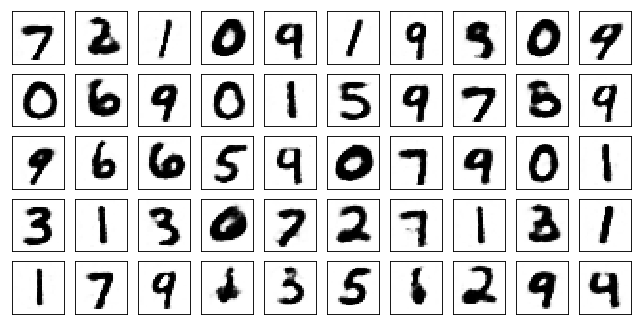

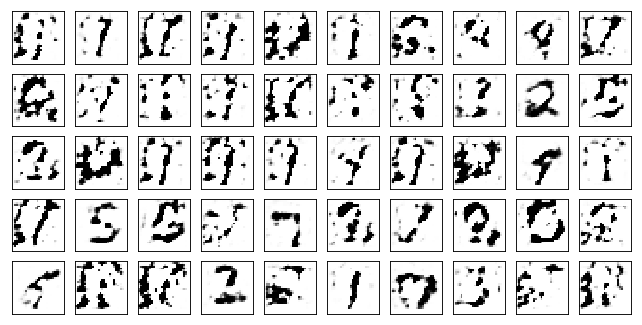

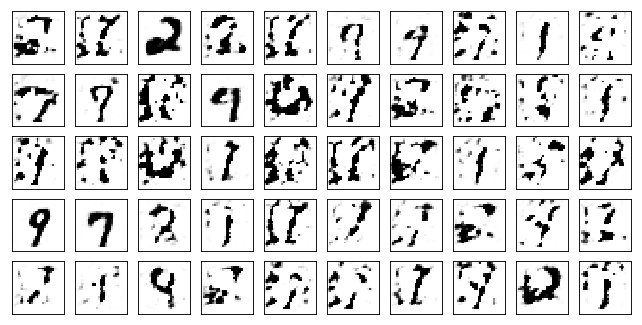

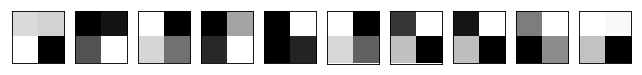

Model Adam Discr+dp:


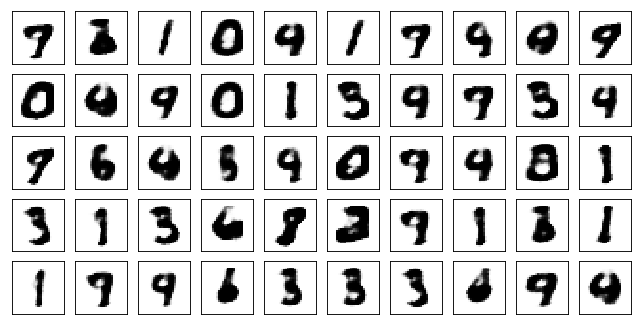

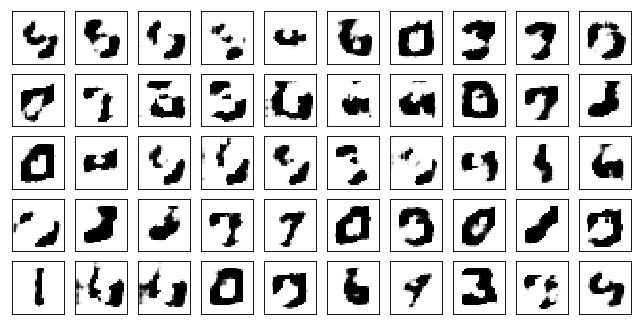

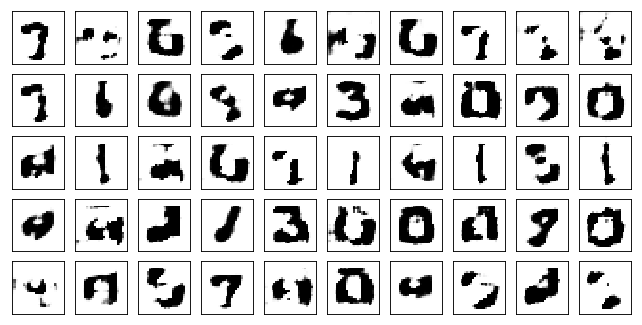

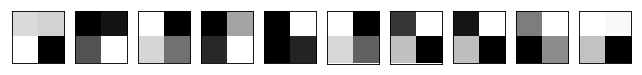

Model Adam Discr+bn+dp:


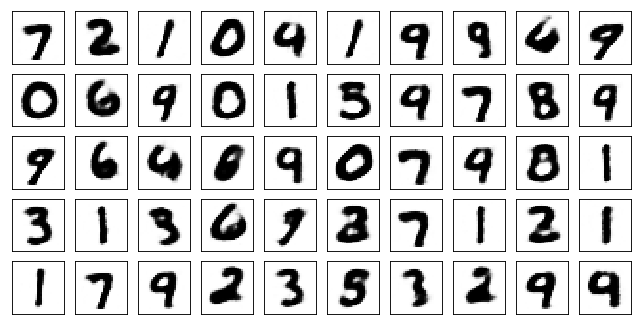

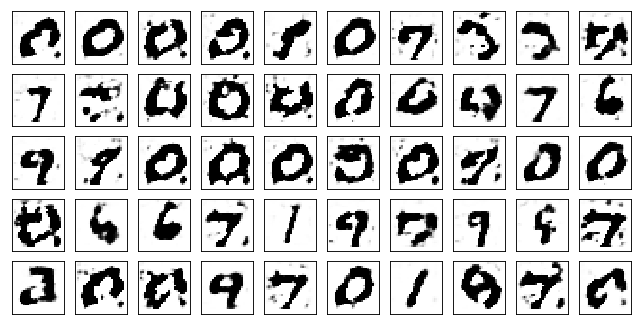

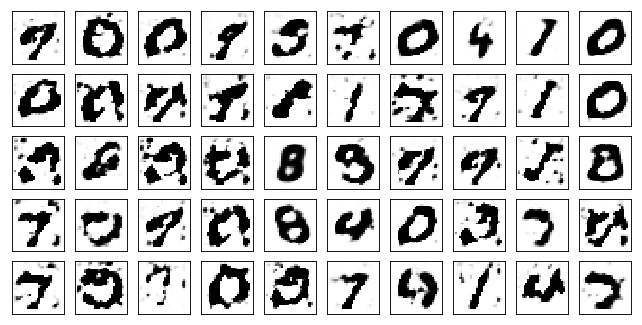

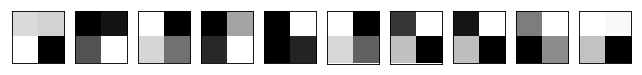

Test losses: 
Adam Discr+bn: 3.05508971 / 1.99460816 / 0.29435649 
Adam Discr+dp: 3.25331903 / 2.00571299 / 0.28710014 
Adam Discr+bn+dp: 3.15270472 / 2.03025699 / 0.27967845 

Train Epoch: 51 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.0042 D:0.1357 Adam Discr+dp: AE:1.0549 D:0.1009 Adam Discr+bn+dp: AE:1.0619 D:0.0175
Train Epoch: 51 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.0092 D:0.0862 Adam Discr+dp: AE:1.0916 D:0.0206 Adam Discr+bn+dp: AE:1.0859 D:0.0928
Train Epoch: 51 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:0.9761 D:0.0414 Adam Discr+dp: AE:1.0259 D:0.0724 Adam Discr+bn+dp: AE:1.0250 D:0.0651
Test losses: 
Adam Discr+bn: 3.05086517 / 1.94223309 / 0.29715546 
Adam Discr+dp: 3.24576831 / 1.95351386 / 0.27845292 
Adam Discr+bn+dp: 3.15121937 / 1.99535716 / 0.29088699 

Train Epoch: 52 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.0222 D:0.0496 Adam Discr+dp: AE:1.0755 D:0.0156 Adam Discr+bn+dp: AE:1.0393 D:0.0886
Train Epoch: 52 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:0.

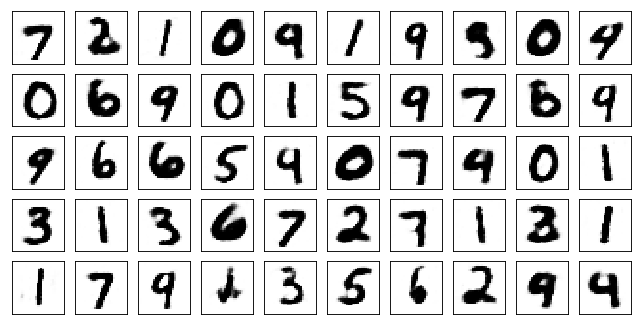

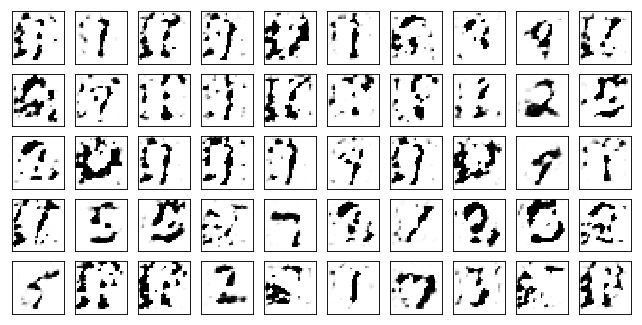

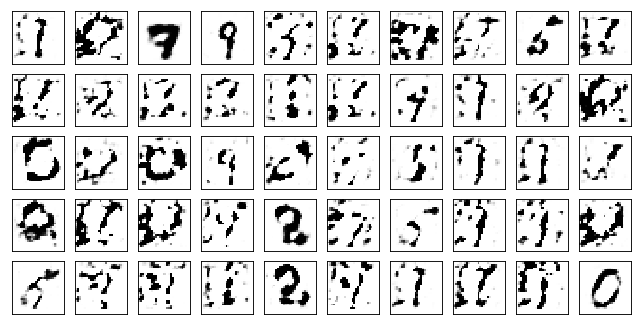

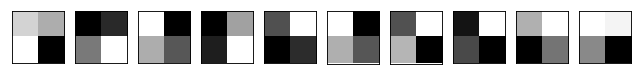

Model Adam Discr+dp:


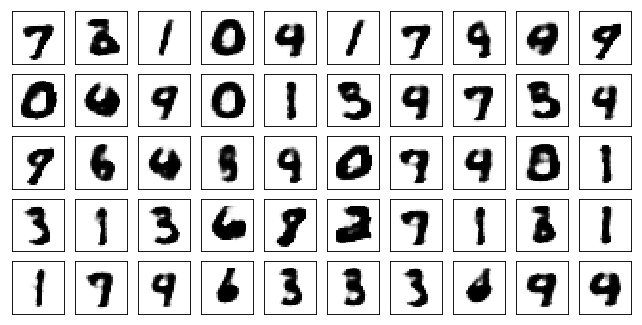

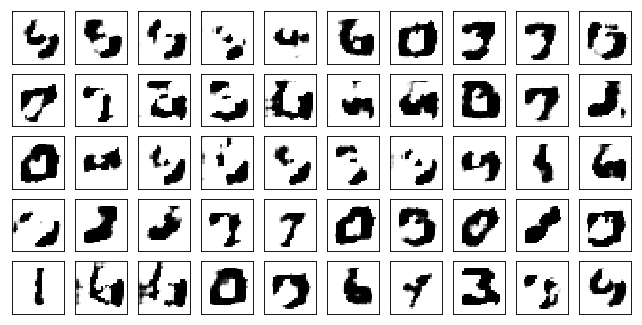

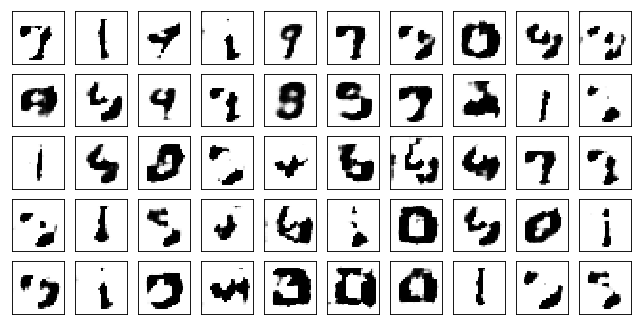

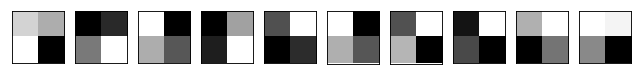

Model Adam Discr+bn+dp:


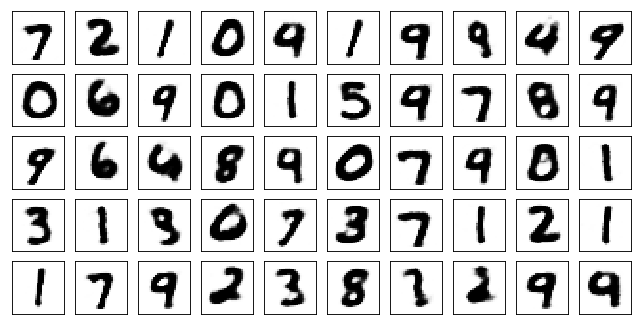

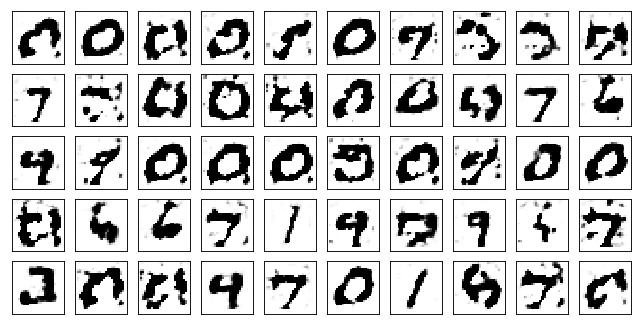

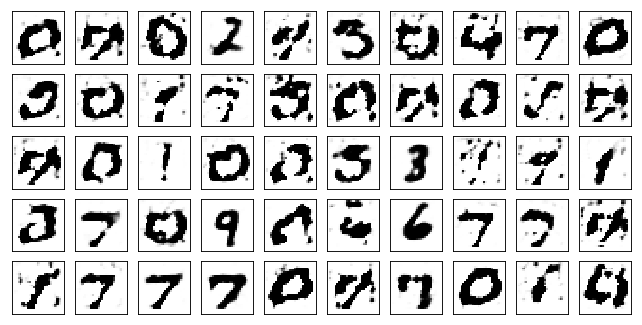

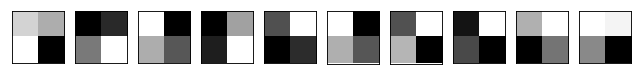

Test losses: 
Adam Discr+bn: 3.03349853 / 1.95887315 / 0.29002074 
Adam Discr+dp: 3.20305920 / 2.00160027 / 0.28406983 
Adam Discr+bn+dp: 3.11289883 / 2.04499912 / 0.27416934 

Train Epoch: 61 [0/50000 (0%)]	Losses Adam Discr+bn: AE:0.9422 D:0.0662 Adam Discr+dp: AE:0.9793 D:0.0639 Adam Discr+bn+dp: AE:0.9540 D:0.0278
Train Epoch: 61 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:0.9818 D:0.0186 Adam Discr+dp: AE:1.0321 D:0.1374 Adam Discr+bn+dp: AE:1.0070 D:0.1965
Train Epoch: 61 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.0104 D:0.0263 Adam Discr+dp: AE:1.0265 D:0.0759 Adam Discr+bn+dp: AE:1.0199 D:0.1335
Test losses: 
Adam Discr+bn: 3.02836871 / 2.01103139 / 0.29075920 
Adam Discr+dp: 3.20034146 / 2.04807663 / 0.27377835 
Adam Discr+bn+dp: 3.11348534 / 2.05338073 / 0.27986179 

Train Epoch: 62 [0/50000 (0%)]	Losses Adam Discr+bn: AE:0.9493 D:0.0867 Adam Discr+dp: AE:0.9952 D:0.0553 Adam Discr+bn+dp: AE:1.0066 D:0.1303
Train Epoch: 62 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:0.

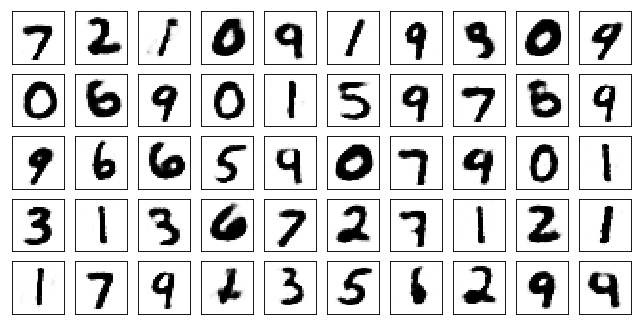

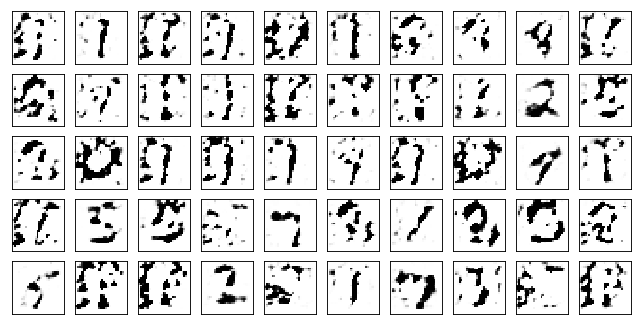

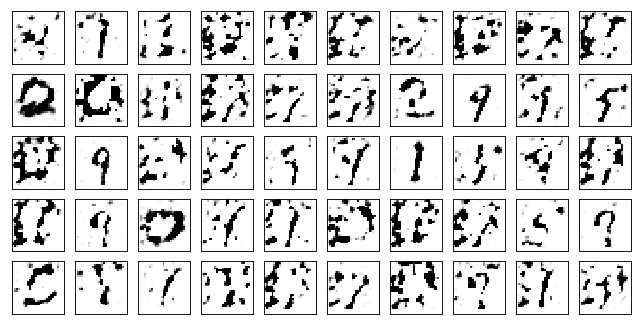

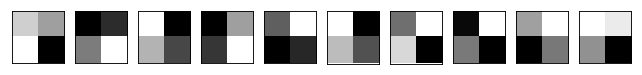

Model Adam Discr+dp:


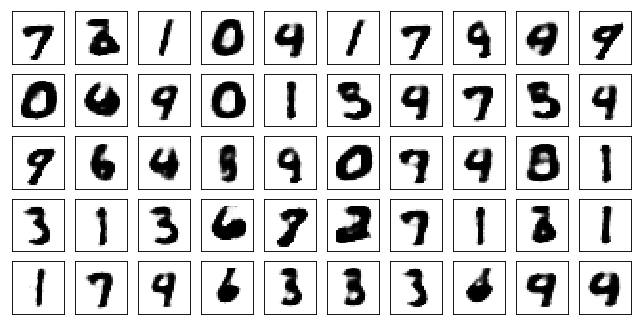

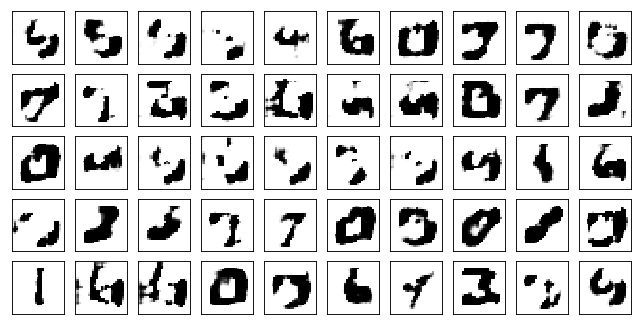

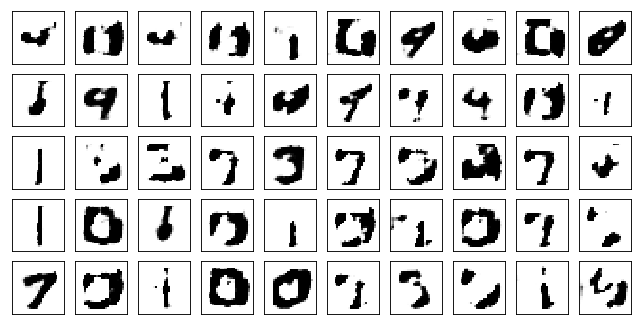

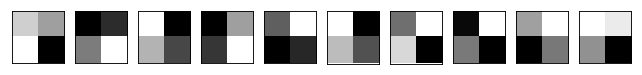

Model Adam Discr+bn+dp:


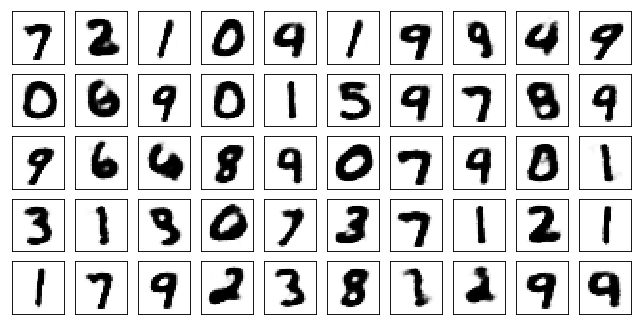

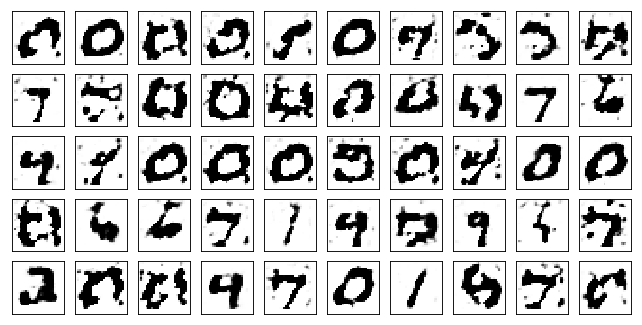

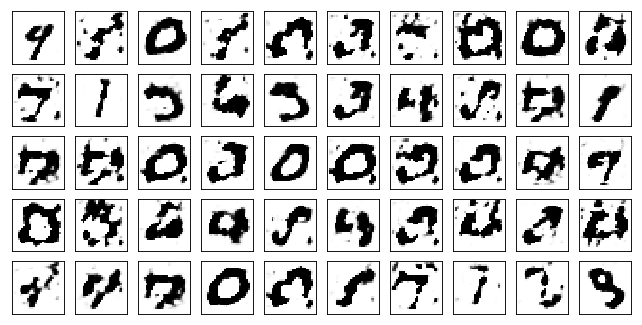

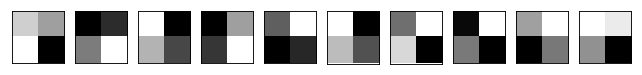

Test losses: 
Adam Discr+bn: 3.01753592 / 1.98565865 / 0.28514993 
Adam Discr+dp: 3.16927147 / 2.00705862 / 0.27088574 
Adam Discr+bn+dp: 3.09743667 / 2.08443117 / 0.26175627 

Train Epoch: 71 [0/50000 (0%)]	Losses Adam Discr+bn: AE:0.9920 D:0.0155 Adam Discr+dp: AE:1.0282 D:0.0647 Adam Discr+bn+dp: AE:1.0240 D:0.0495
Train Epoch: 71 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.0056 D:0.1040 Adam Discr+dp: AE:1.0573 D:0.0979 Adam Discr+bn+dp: AE:1.0391 D:0.0187
Train Epoch: 71 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:0.9886 D:0.1521 Adam Discr+dp: AE:1.0798 D:0.0485 Adam Discr+bn+dp: AE:1.0401 D:0.0142
Test losses: 
Adam Discr+bn: 3.01437545 / 1.93470764 / 0.27656101 
Adam Discr+dp: 3.16501546 / 2.14951706 / 0.27799664 
Adam Discr+bn+dp: 3.09913135 / 2.10851455 / 0.27582078 

Train Epoch: 72 [0/50000 (0%)]	Losses Adam Discr+bn: AE:0.9709 D:0.0172 Adam Discr+dp: AE:1.0744 D:0.0231 Adam Discr+bn+dp: AE:1.0518 D:0.0887
Train Epoch: 72 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:0.

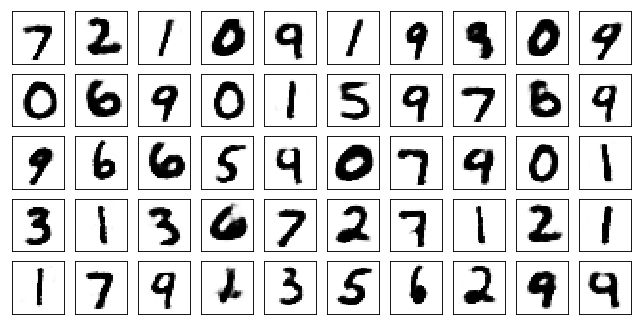

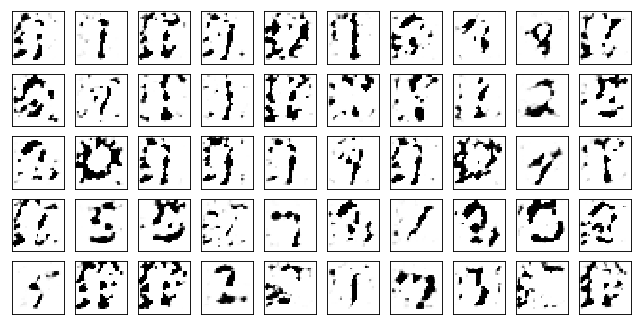

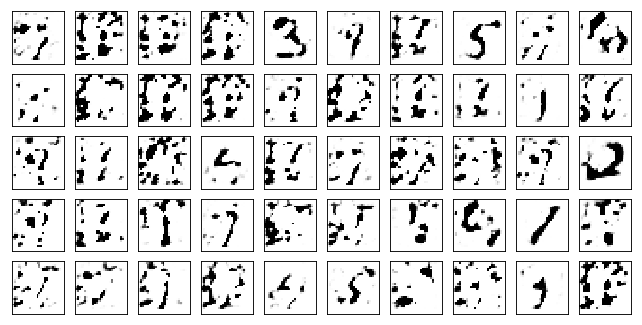

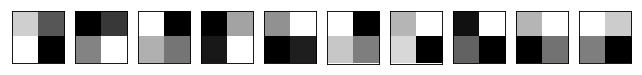

Model Adam Discr+dp:


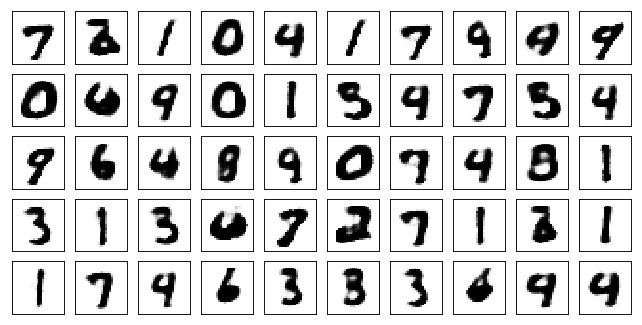

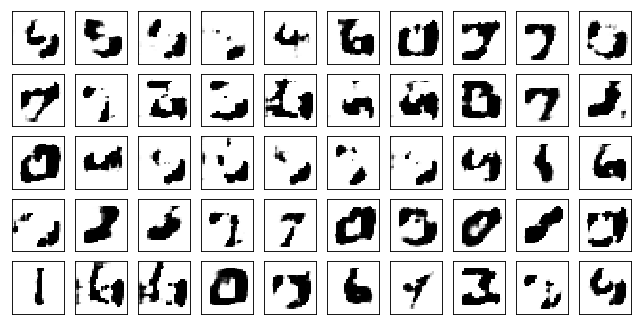

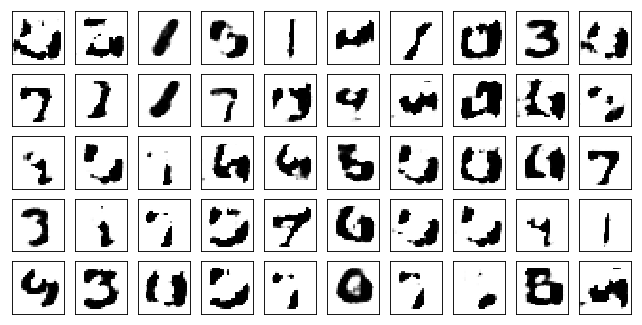

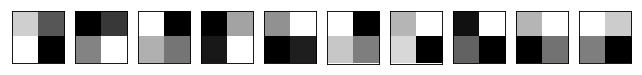

Model Adam Discr+bn+dp:


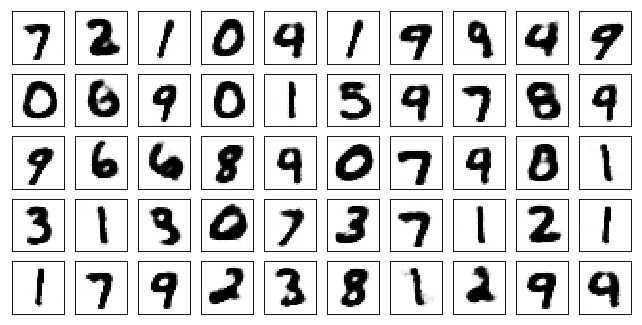

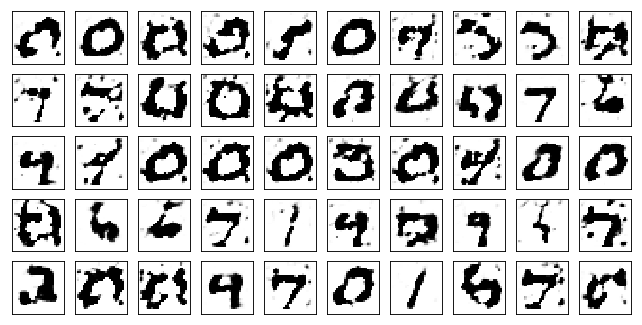

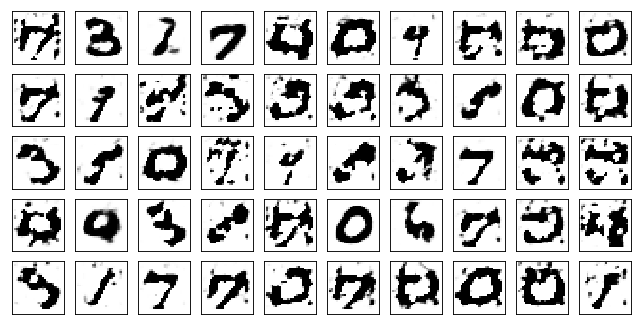

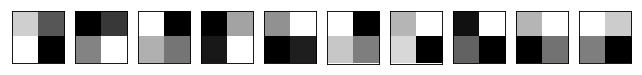

Test losses: 
Adam Discr+bn: 3.00940299 / 2.06686831 / 0.29353377 
Adam Discr+dp: 3.14873528 / 2.07820392 / 0.26124895 
Adam Discr+bn+dp: 3.08574033 / 2.02885246 / 0.25919038 

Train Epoch: 81 [0/50000 (0%)]	Losses Adam Discr+bn: AE:0.9917 D:0.0340 Adam Discr+dp: AE:0.9976 D:0.0631 Adam Discr+bn+dp: AE:0.9790 D:0.0839
Train Epoch: 81 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.0185 D:0.0518 Adam Discr+dp: AE:1.0276 D:0.0606 Adam Discr+bn+dp: AE:1.0406 D:0.0210
Train Epoch: 81 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:0.9691 D:0.0228 Adam Discr+dp: AE:1.0065 D:0.0527 Adam Discr+bn+dp: AE:1.0251 D:0.0274
Test losses: 
Adam Discr+bn: 2.99993634 / 2.00173712 / 0.26858515 
Adam Discr+dp: 3.15043354 / 2.06000829 / 0.26619501 
Adam Discr+bn+dp: 3.08652449 / 2.12593627 / 0.26730304 

Train Epoch: 82 [0/50000 (0%)]	Losses Adam Discr+bn: AE:0.9807 D:0.0405 Adam Discr+dp: AE:1.0441 D:0.0506 Adam Discr+bn+dp: AE:1.0465 D:0.0599
Train Epoch: 82 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:0.

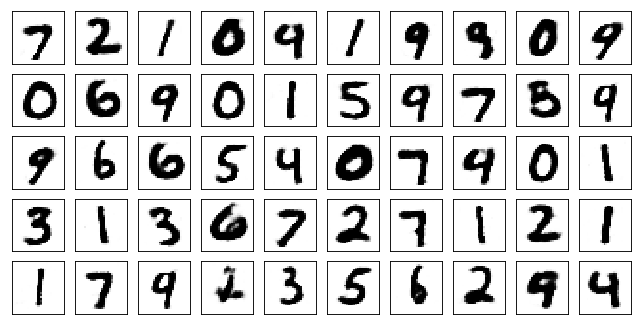

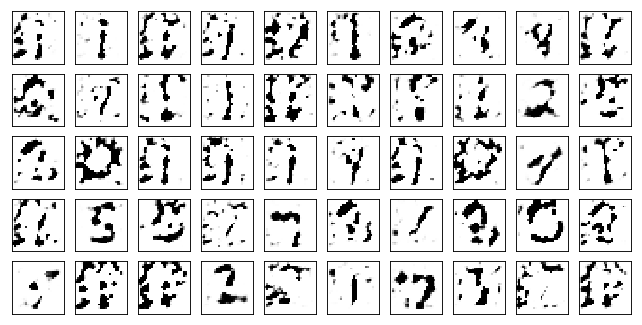

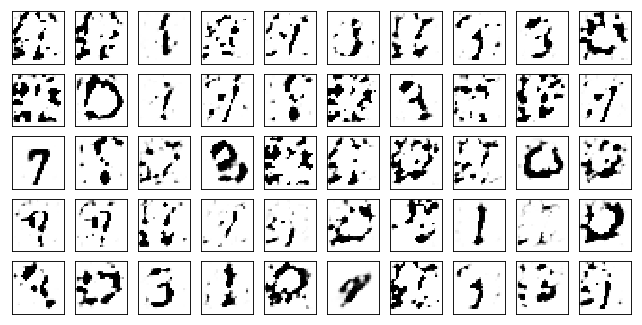

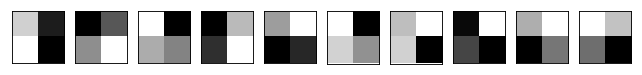

Model Adam Discr+dp:


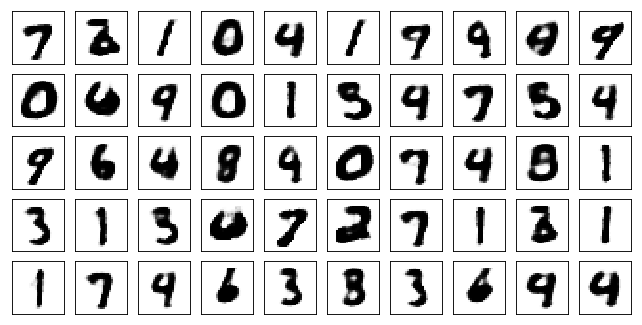

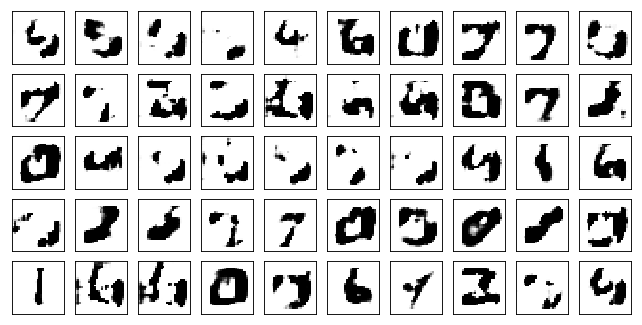

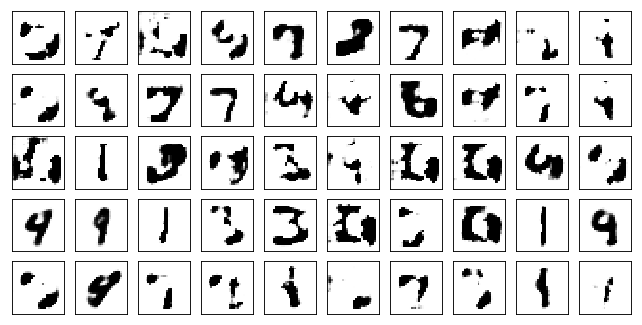

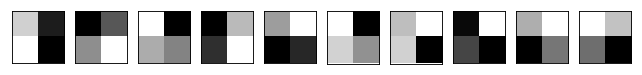

Model Adam Discr+bn+dp:


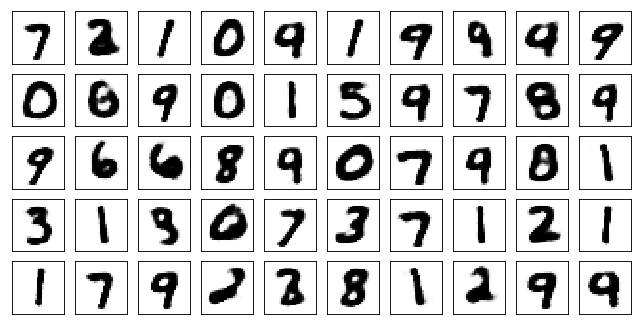

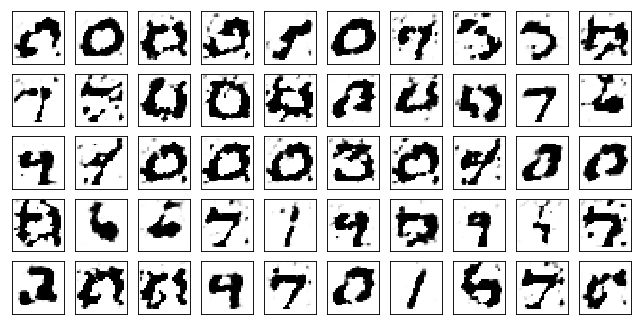

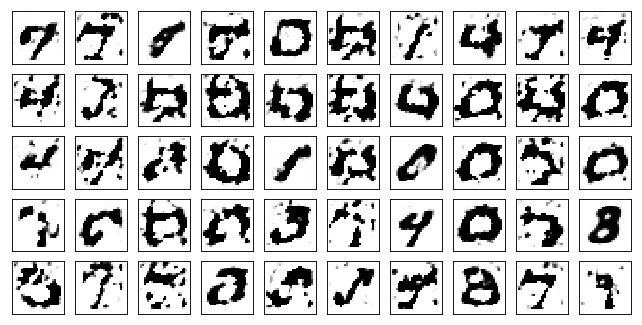

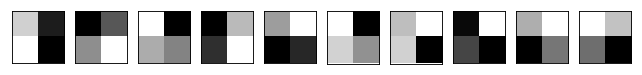

Test losses: 
Adam Discr+bn: 2.99695373 / 2.04045844 / 0.26608833 
Adam Discr+dp: 3.13084531 / 1.99944162 / 0.24262052 
Adam Discr+bn+dp: 3.08038163 / 2.08842182 / 0.26874608 

Train Epoch: 91 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.0004 D:0.0197 Adam Discr+dp: AE:1.0360 D:0.0427 Adam Discr+bn+dp: AE:1.0195 D:0.0276
Train Epoch: 91 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:0.9907 D:0.0716 Adam Discr+dp: AE:1.0795 D:0.1319 Adam Discr+bn+dp: AE:1.0177 D:0.0615
Train Epoch: 91 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.0287 D:0.0115 Adam Discr+dp: AE:1.0658 D:0.0463 Adam Discr+bn+dp: AE:1.0384 D:0.0506
Test losses: 
Adam Discr+bn: 2.99147272 / 2.14029408 / 0.27999841 
Adam Discr+dp: 3.12952137 / 2.17055488 / 0.25390082 
Adam Discr+bn+dp: 3.08153534 / 2.07408071 / 0.24332250 

Train Epoch: 92 [0/50000 (0%)]	Losses Adam Discr+bn: AE:0.9942 D:0.0105 Adam Discr+dp: AE:1.0673 D:0.0108 Adam Discr+bn+dp: AE:1.0292 D:0.0503
Train Epoch: 92 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.

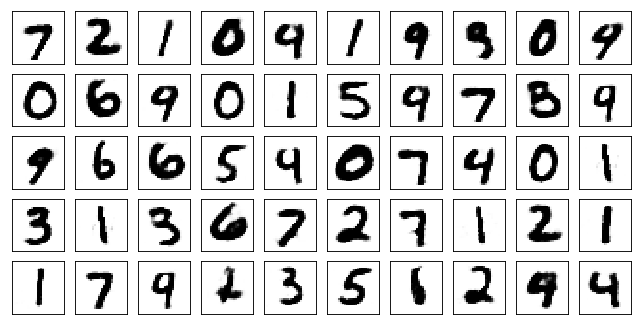

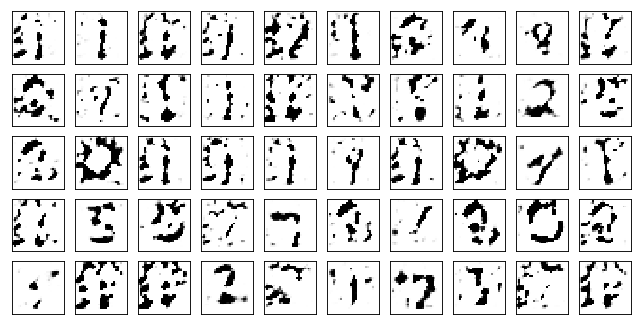

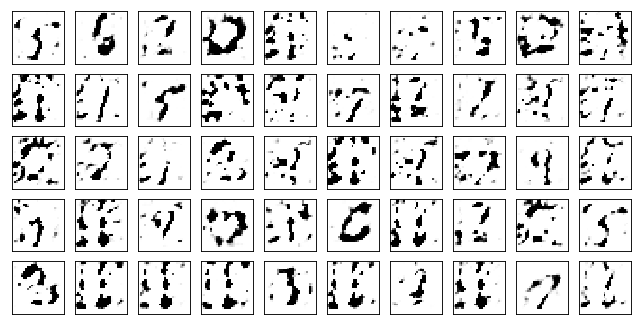

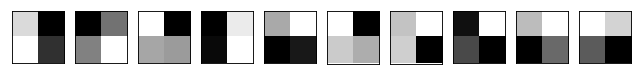

Model Adam Discr+dp:


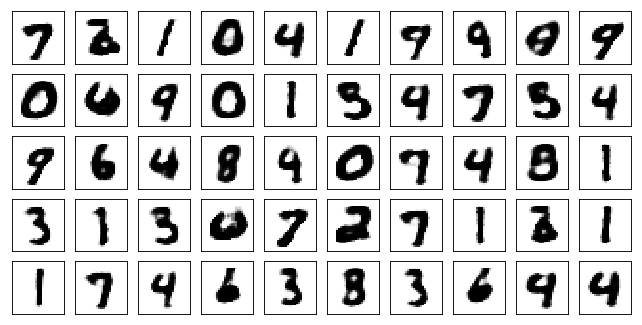

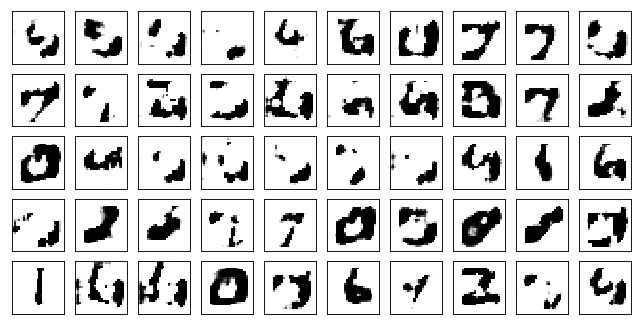

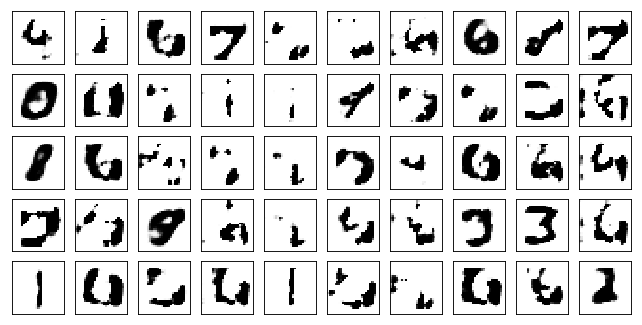

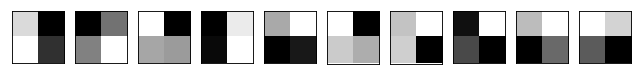

Model Adam Discr+bn+dp:


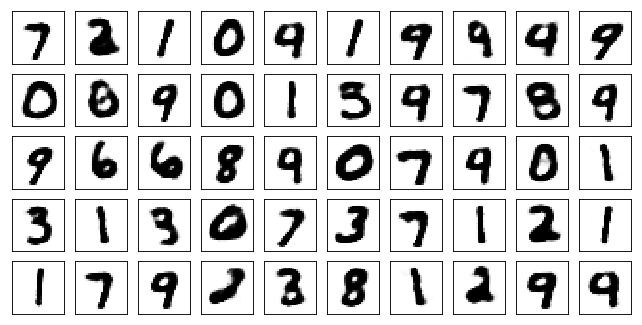

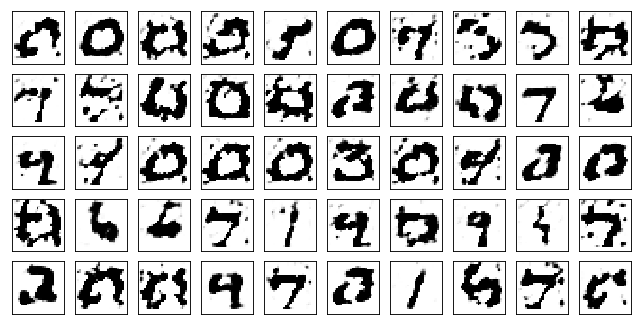

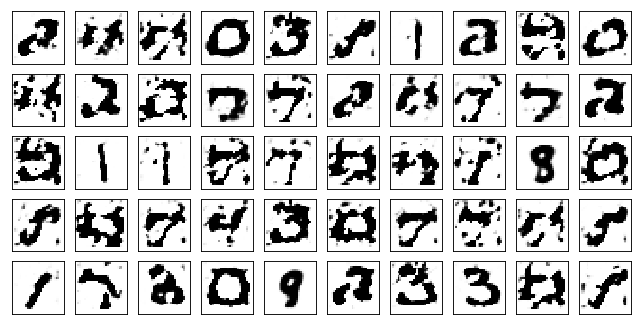

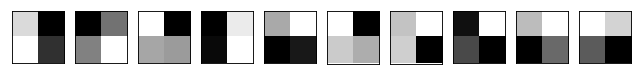

Test losses: 
Adam Discr+bn: 2.98587346 / 2.11640835 / 0.25518760 
Adam Discr+dp: 3.12052298 / 2.08097625 / 0.24101471 
Adam Discr+bn+dp: 3.07439351 / 2.16423774 / 0.26338060 

Train Epoch: 101 [0/50000 (0%)]	Losses Adam Discr+bn: AE:0.9866 D:0.0136 Adam Discr+dp: AE:1.0599 D:0.0120 Adam Discr+bn+dp: AE:1.0397 D:0.0600
Train Epoch: 101 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:0.9792 D:0.0157 Adam Discr+dp: AE:1.0689 D:0.0460 Adam Discr+bn+dp: AE:1.0057 D:0.0621
Train Epoch: 101 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.0071 D:0.0618 Adam Discr+dp: AE:1.0810 D:0.1189 Adam Discr+bn+dp: AE:1.0573 D:0.0522
Test losses: 
Adam Discr+bn: 2.98296571 / 2.04747319 / 0.25543522 
Adam Discr+dp: 3.11627650 / 2.02338886 / 0.24380547 
Adam Discr+bn+dp: 3.07080317 / 2.11385632 / 0.26438545 

Train Epoch: 102 [0/50000 (0%)]	Losses Adam Discr+bn: AE:0.9856 D:0.1332 Adam Discr+dp: AE:1.0066 D:0.0142 Adam Discr+bn+dp: AE:1.0604 D:0.0220
Train Epoch: 102 [25000/50000 (50%)]	Losses Adam Discr+bn: 

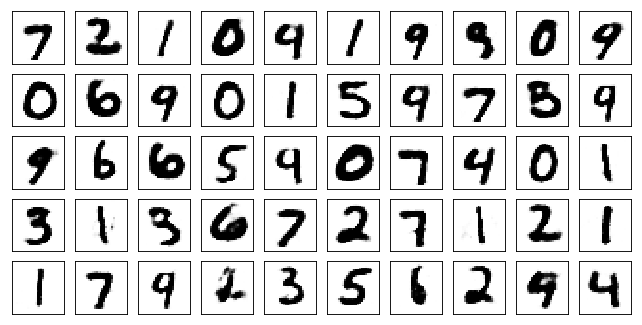

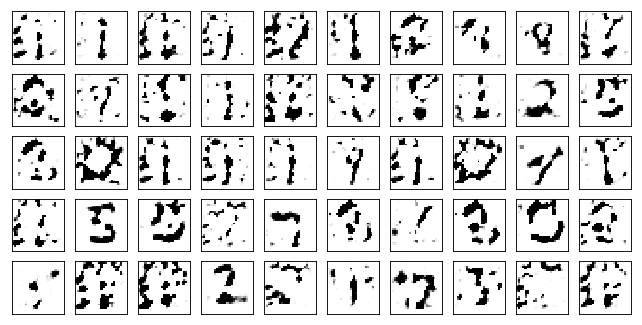

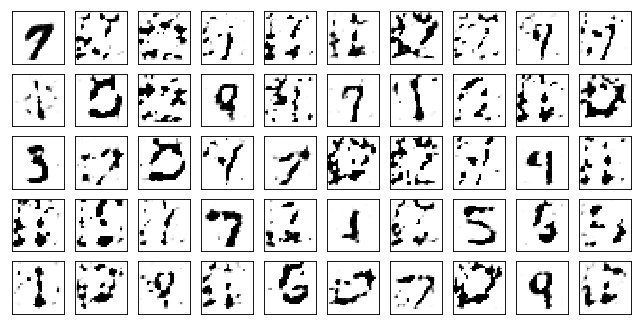

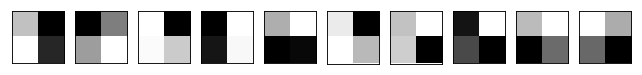

Model Adam Discr+dp:


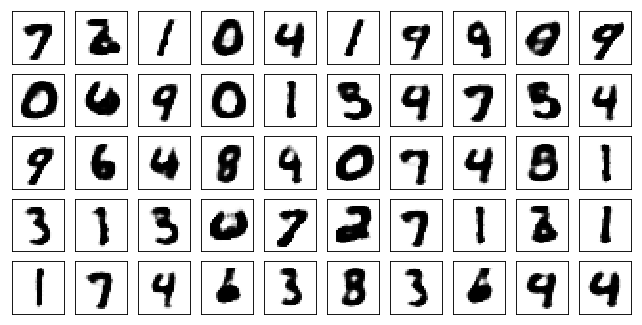

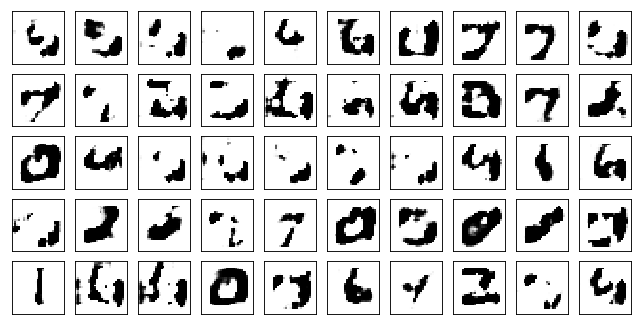

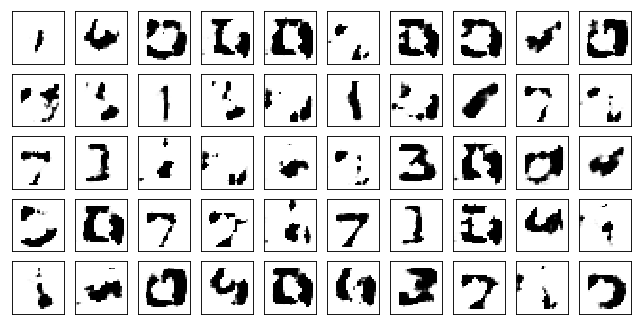

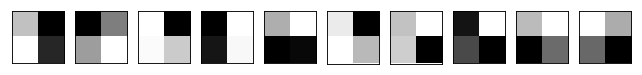

Model Adam Discr+bn+dp:


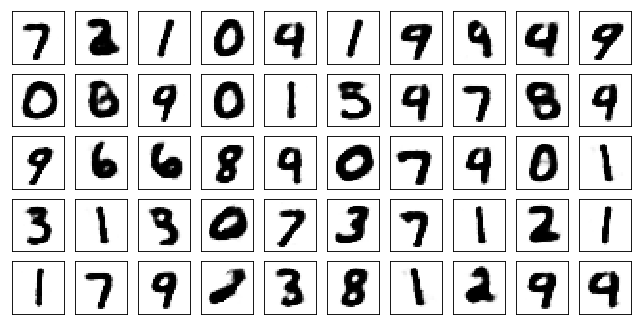

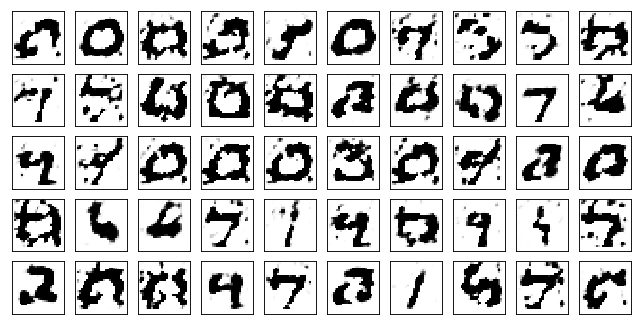

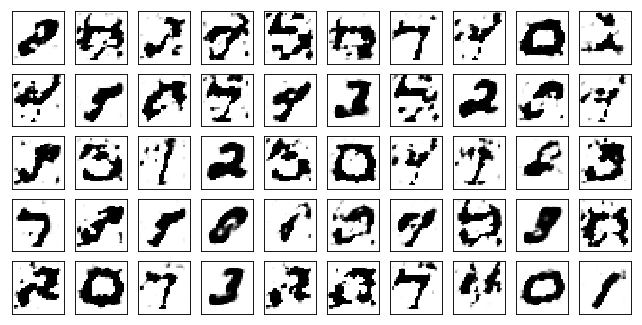

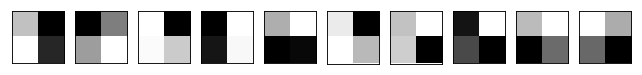

Test losses: 
Adam Discr+bn: 2.98058367 / 2.09941196 / 0.26461400 
Adam Discr+dp: 3.10897636 / 2.05704761 / 0.23542686 
Adam Discr+bn+dp: 3.06661677 / 2.16995621 / 0.25080251 

Train Epoch: 111 [0/50000 (0%)]	Losses Adam Discr+bn: AE:0.9715 D:0.0934 Adam Discr+dp: AE:1.0015 D:0.1297 Adam Discr+bn+dp: AE:1.0197 D:0.0887
Train Epoch: 111 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.0062 D:0.0136 Adam Discr+dp: AE:1.0449 D:0.1386 Adam Discr+bn+dp: AE:1.0279 D:0.0493
Train Epoch: 111 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:0.9850 D:0.1163 Adam Discr+dp: AE:1.0107 D:0.0458 Adam Discr+bn+dp: AE:1.0163 D:0.0916
Test losses: 
Adam Discr+bn: 2.97873616 / 2.11071277 / 0.25513909 
Adam Discr+dp: 3.10749221 / 2.08385515 / 0.24148849 
Adam Discr+bn+dp: 3.06382799 / 2.02472138 / 0.24717682 

Train Epoch: 112 [0/50000 (0%)]	Losses Adam Discr+bn: AE:0.9858 D:0.1440 Adam Discr+dp: AE:1.0350 D:0.0187 Adam Discr+bn+dp: AE:0.9974 D:0.0842
Train Epoch: 112 [25000/50000 (50%)]	Losses Adam Discr+bn: 

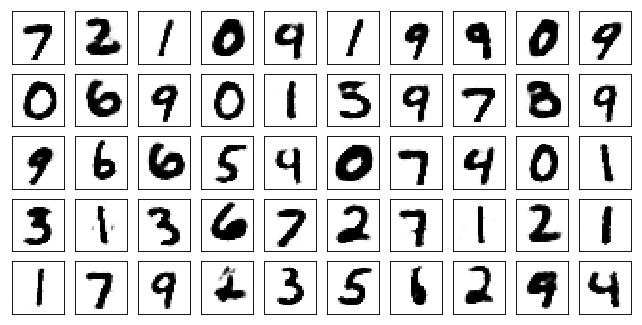

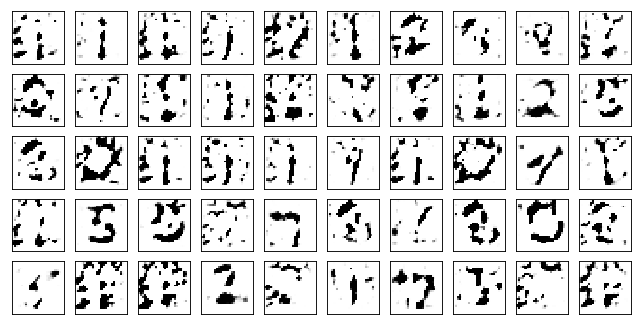

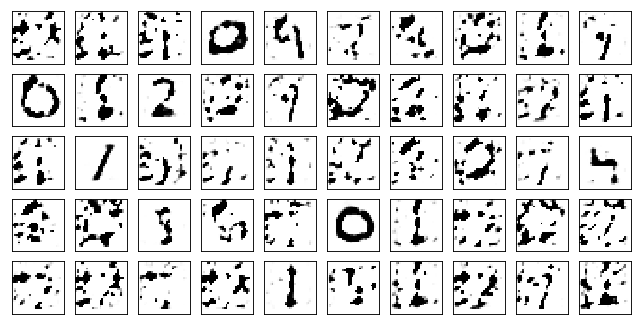

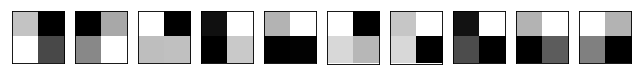

Model Adam Discr+dp:


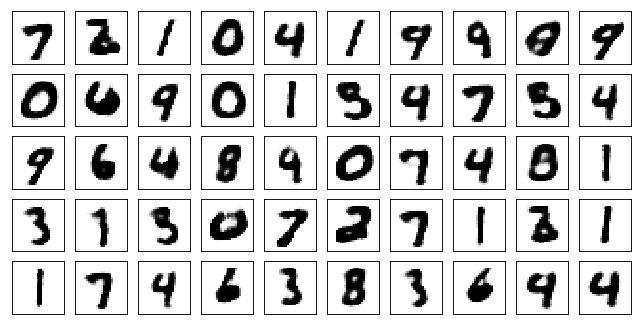

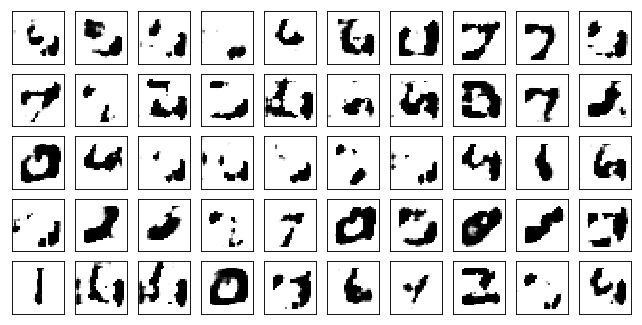

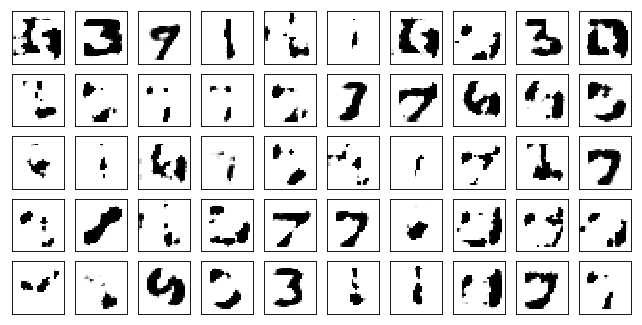

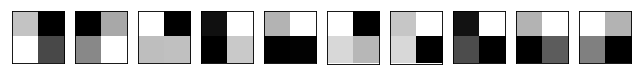

Model Adam Discr+bn+dp:


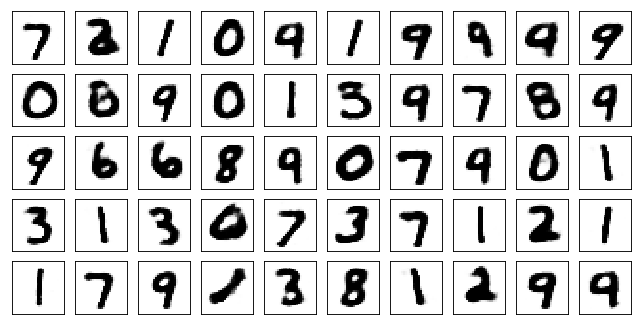

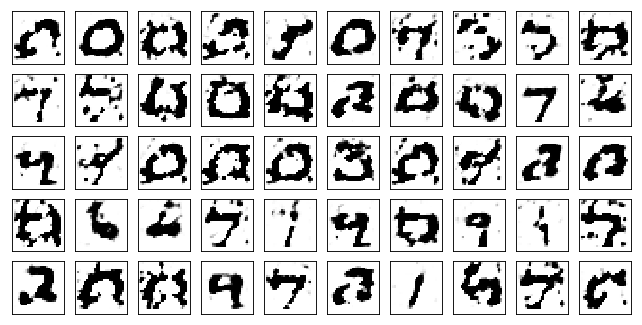

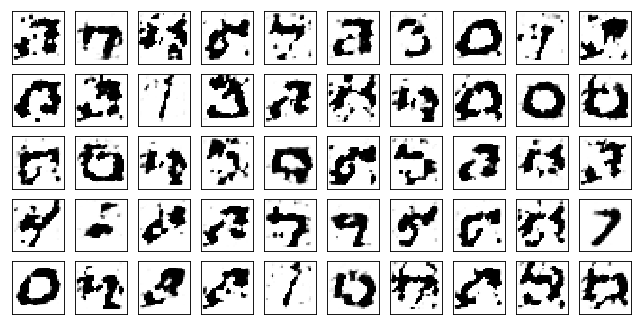

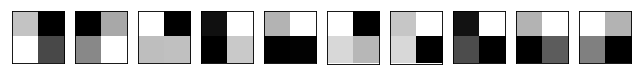

Test losses: 
Adam Discr+bn: 2.96994615 / 2.08809018 / 0.26021130 
Adam Discr+dp: 3.09853745 / 2.16389823 / 0.25339608 
Adam Discr+bn+dp: 3.05924392 / 2.08014393 / 0.24831226 

Train Epoch: 121 [0/50000 (0%)]	Losses Adam Discr+bn: AE:0.9780 D:0.0157 Adam Discr+dp: AE:1.0242 D:0.0273 Adam Discr+bn+dp: AE:0.9977 D:0.0441
Train Epoch: 121 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:0.9925 D:0.0146 Adam Discr+dp: AE:1.0538 D:0.0155 Adam Discr+bn+dp: AE:1.0248 D:0.0118
Train Epoch: 121 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.0066 D:0.0719 Adam Discr+dp: AE:1.0627 D:0.0632 Adam Discr+bn+dp: AE:1.0819 D:0.0322
Test losses: 
Adam Discr+bn: 2.96964526 / 2.09651446 / 0.24850078 
Adam Discr+dp: 3.09840107 / 2.11286139 / 0.24321360 
Adam Discr+bn+dp: 3.05812240 / 2.14897585 / 0.24254760 

Train Epoch: 122 [0/50000 (0%)]	Losses Adam Discr+bn: AE:0.9880 D:0.0434 Adam Discr+dp: AE:1.0116 D:0.0873 Adam Discr+bn+dp: AE:1.0248 D:0.1013
Train Epoch: 122 [25000/50000 (50%)]	Losses Adam Discr+bn: 

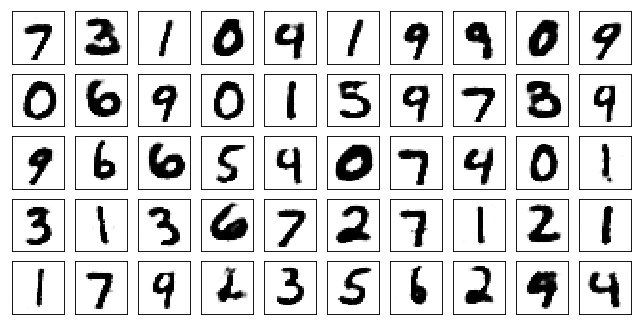

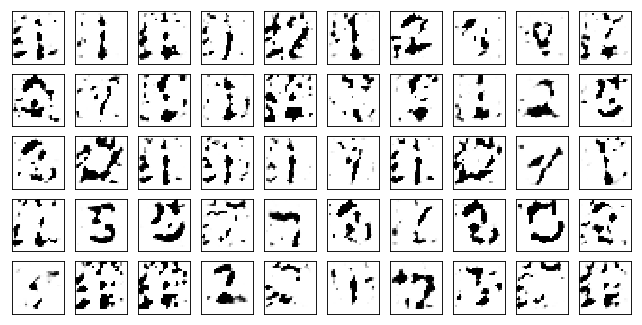

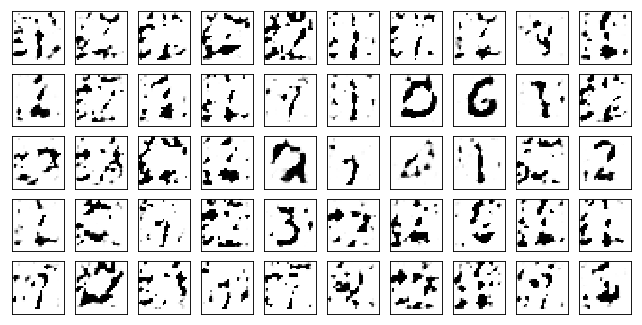

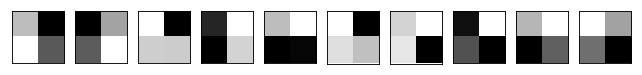

Model Adam Discr+dp:


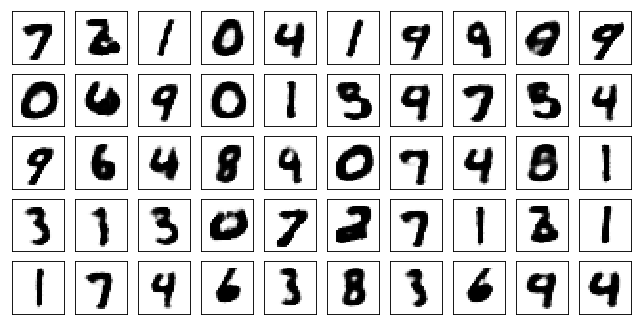

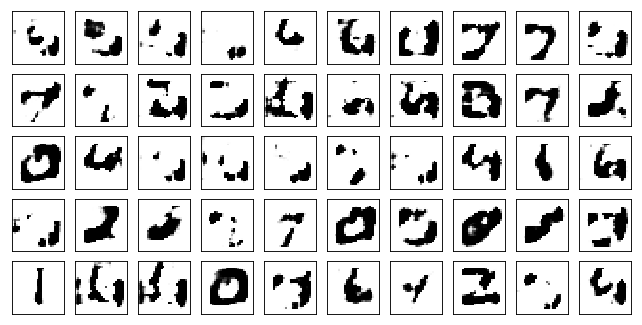

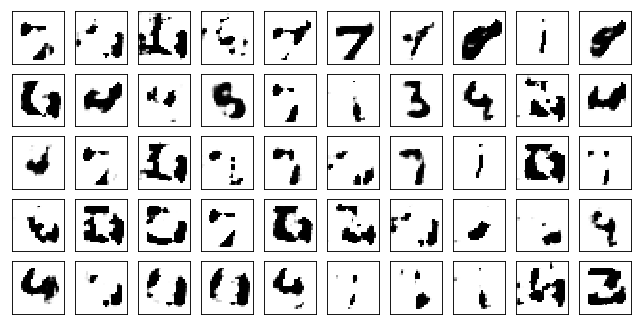

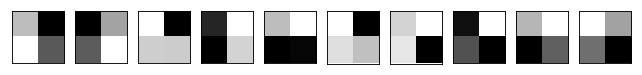

Model Adam Discr+bn+dp:


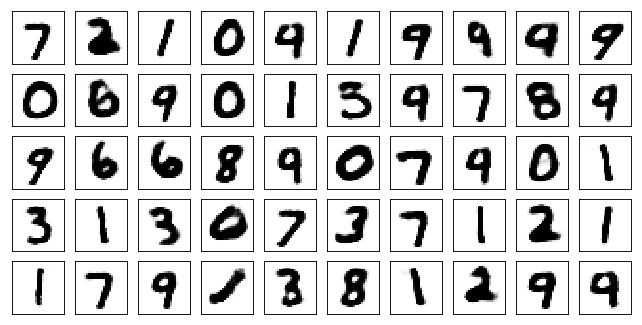

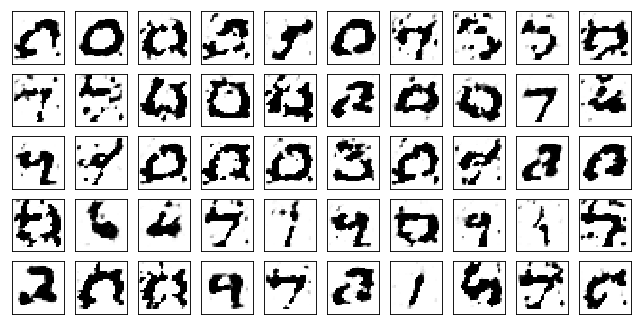

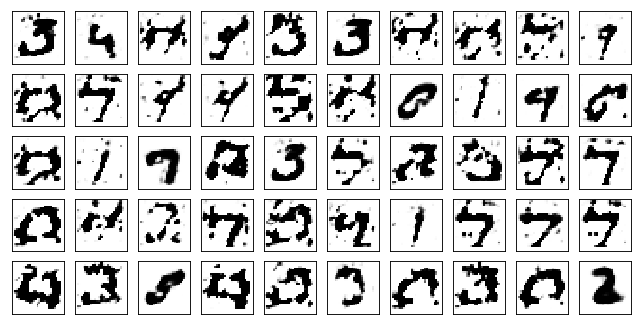

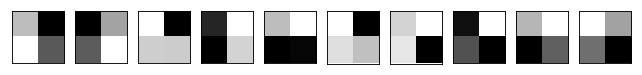

Test losses: 
Adam Discr+bn: 2.96657705 / 2.07272387 / 0.24860442 
Adam Discr+dp: 3.09073520 / 2.21521425 / 0.23890868 
Adam Discr+bn+dp: 3.05251694 / 2.10841346 / 0.23762843 

Train Epoch: 131 [0/50000 (0%)]	Losses Adam Discr+bn: AE:0.9704 D:0.1344 Adam Discr+dp: AE:1.0339 D:0.0542 Adam Discr+bn+dp: AE:1.0154 D:0.0918
Train Epoch: 131 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.0326 D:0.0541 Adam Discr+dp: AE:1.0379 D:0.0405 Adam Discr+bn+dp: AE:1.0831 D:0.0744
Train Epoch: 131 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.0173 D:0.0373 Adam Discr+dp: AE:1.0379 D:0.0275 Adam Discr+bn+dp: AE:1.0432 D:0.0388
Test losses: 
Adam Discr+bn: 2.96786547 / 2.01390028 / 0.24350554 
Adam Discr+dp: 3.09374547 / 2.10892892 / 0.22721611 
Adam Discr+bn+dp: 3.05246115 / 2.13778687 / 0.24100989 

Train Epoch: 132 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.0114 D:0.0629 Adam Discr+dp: AE:1.0275 D:0.0219 Adam Discr+bn+dp: AE:1.0442 D:0.0539
Train Epoch: 132 [25000/50000 (50%)]	Losses Adam Discr+bn: 

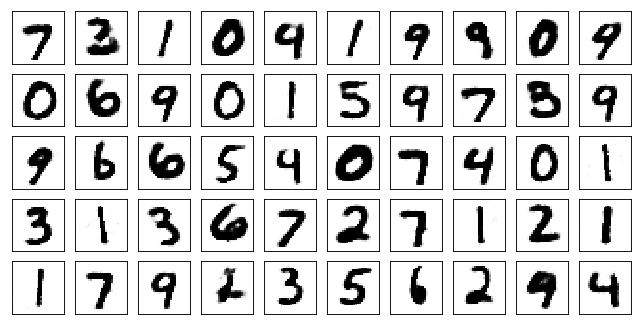

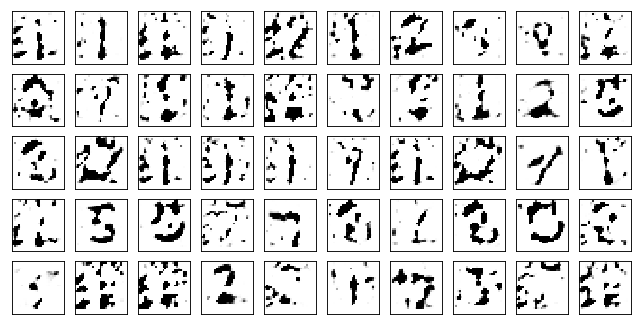

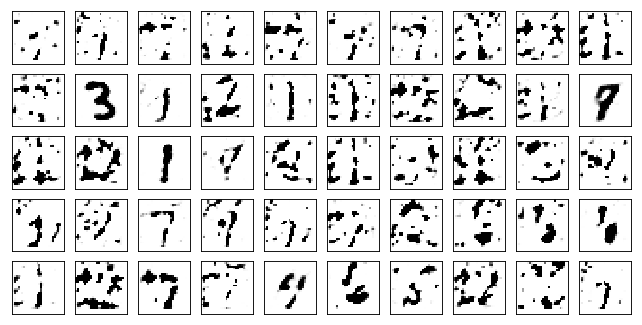

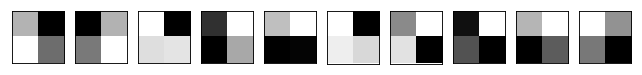

Model Adam Discr+dp:


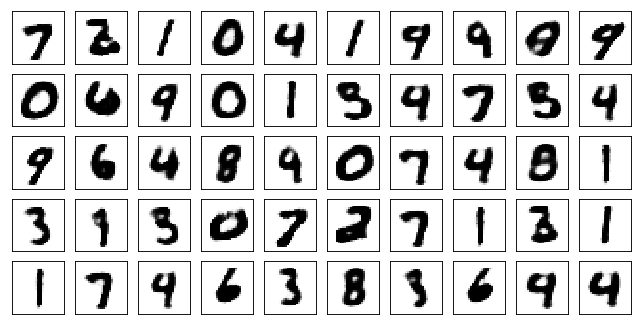

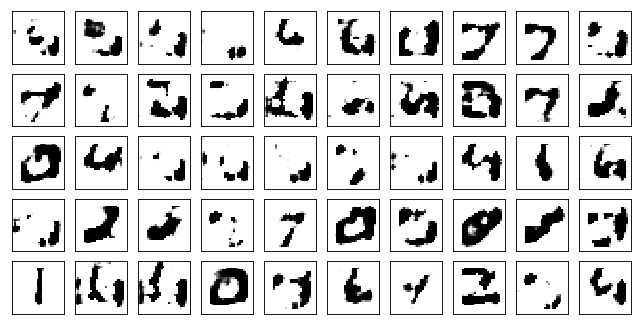

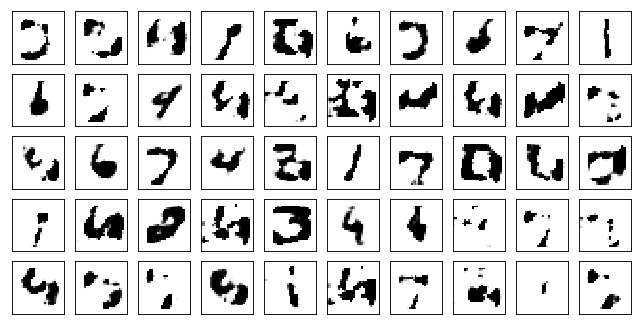

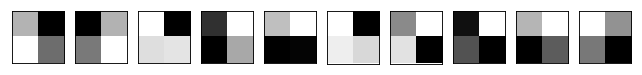

Model Adam Discr+bn+dp:


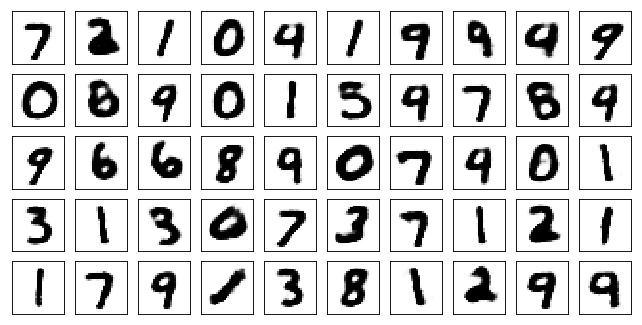

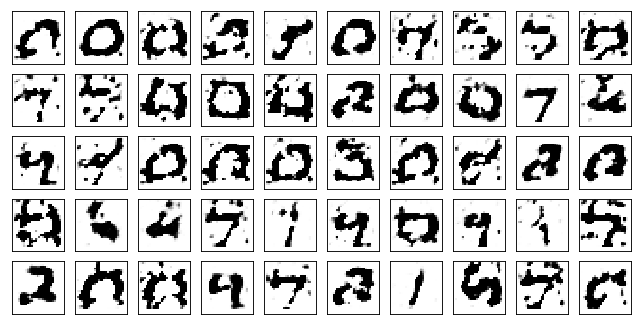

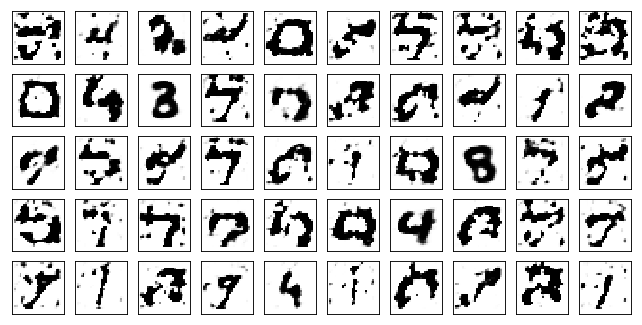

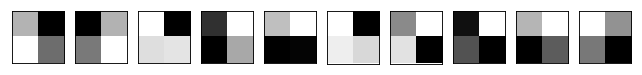

Test losses: 
Adam Discr+bn: 2.96353793 / 2.13823366 / 0.26178730 
Adam Discr+dp: 3.08540392 / 2.27375054 / 0.25349243 
Adam Discr+bn+dp: 3.04940534 / 2.13847280 / 0.24639307 

Train Epoch: 141 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.0268 D:0.0121 Adam Discr+dp: AE:1.1336 D:0.0634 Adam Discr+bn+dp: AE:1.1019 D:0.0366
Train Epoch: 141 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.0053 D:0.0662 Adam Discr+dp: AE:1.0632 D:0.1501 Adam Discr+bn+dp: AE:1.0511 D:0.0120
Train Epoch: 141 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.0188 D:0.0620 Adam Discr+dp: AE:1.0691 D:0.0959 Adam Discr+bn+dp: AE:1.0250 D:0.0445
Test losses: 
Adam Discr+bn: 2.96022940 / 2.19591951 / 0.25246045 
Adam Discr+dp: 3.08484316 / 2.21969795 / 0.24441085 
Adam Discr+bn+dp: 3.04692745 / 2.10055637 / 0.23307401 

Train Epoch: 142 [0/50000 (0%)]	Losses Adam Discr+bn: AE:0.9926 D:0.1079 Adam Discr+dp: AE:1.0281 D:0.0099 Adam Discr+bn+dp: AE:1.0020 D:0.0468
Train Epoch: 142 [25000/50000 (50%)]	Losses Adam Discr+bn: 

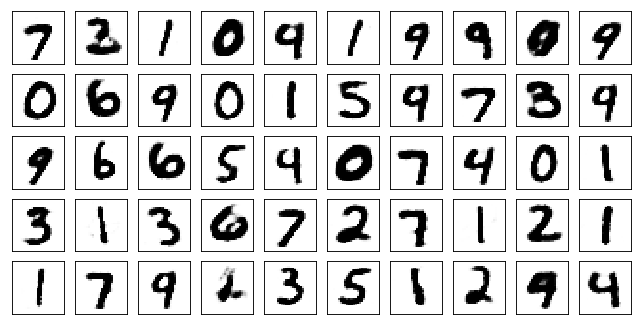

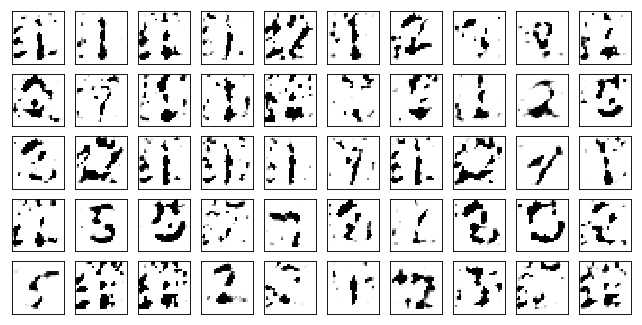

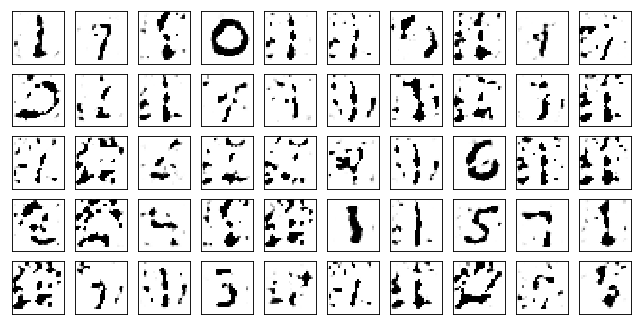

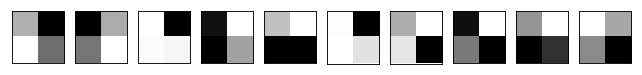

Model Adam Discr+dp:


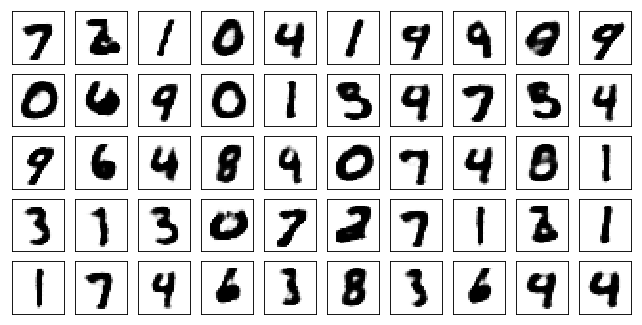

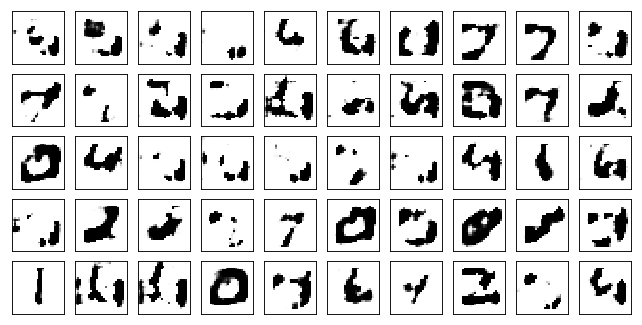

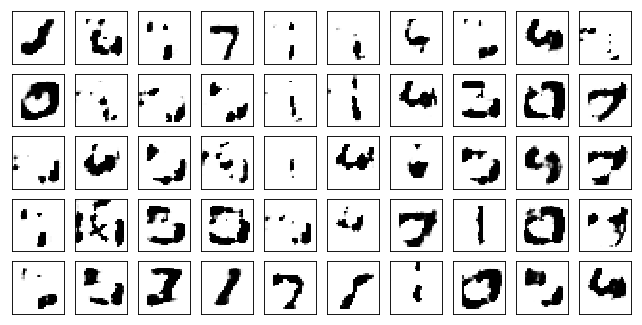

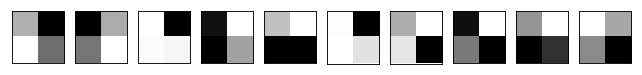

Model Adam Discr+bn+dp:


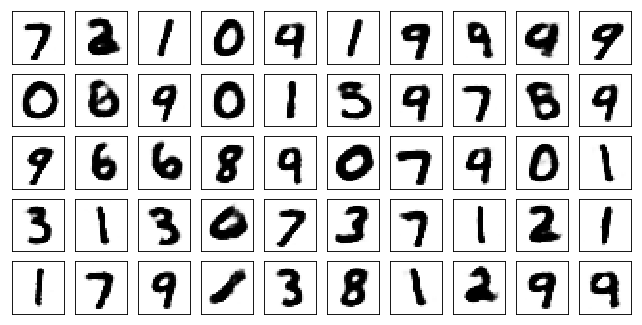

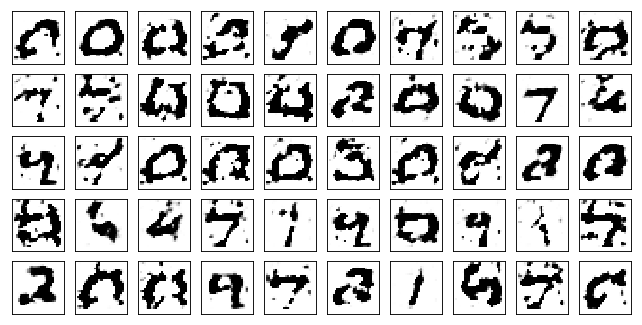

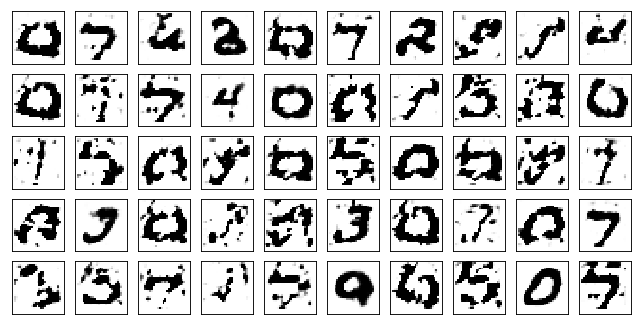

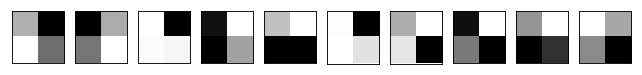

Test losses: 
Adam Discr+bn: 2.95531249 / 2.24009848 / 0.25468354 
Adam Discr+dp: 3.07676172 / 2.14691806 / 0.23775275 
Adam Discr+bn+dp: 3.04350090 / 2.08740377 / 0.23633430 

Train Epoch: 151 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.0774 D:0.0482 Adam Discr+dp: AE:1.0696 D:0.0258 Adam Discr+bn+dp: AE:1.0331 D:0.0840
Train Epoch: 151 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.0099 D:0.0460 Adam Discr+dp: AE:1.0524 D:0.0129 Adam Discr+bn+dp: AE:1.0563 D:0.0584
Train Epoch: 151 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:0.9918 D:0.0622 Adam Discr+dp: AE:1.0355 D:0.0108 Adam Discr+bn+dp: AE:1.0367 D:0.0591
Test losses: 
Adam Discr+bn: 2.95298386 / 2.03726649 / 0.24702665 
Adam Discr+dp: 3.08109283 / 2.13146591 / 0.24837955 
Adam Discr+bn+dp: 3.04512930 / 2.08268952 / 0.23084977 

Train Epoch: 152 [0/50000 (0%)]	Losses Adam Discr+bn: AE:0.9693 D:0.0169 Adam Discr+dp: AE:1.0237 D:0.0604 Adam Discr+bn+dp: AE:0.9869 D:0.0153
Train Epoch: 152 [25000/50000 (50%)]	Losses Adam Discr+bn: 

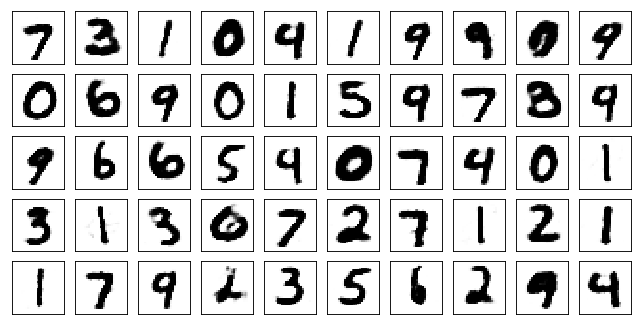

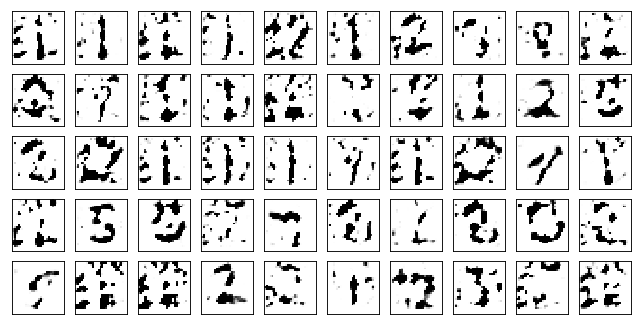

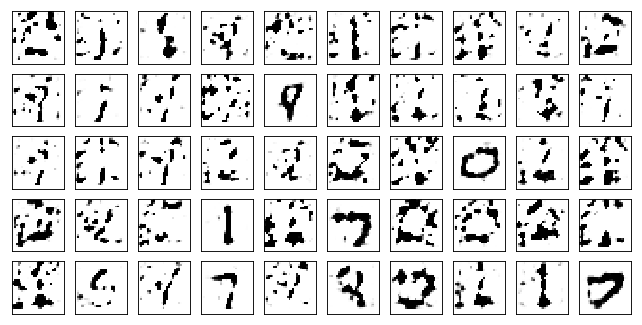

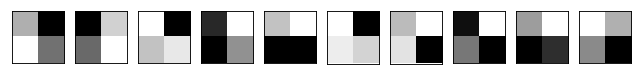

Model Adam Discr+dp:


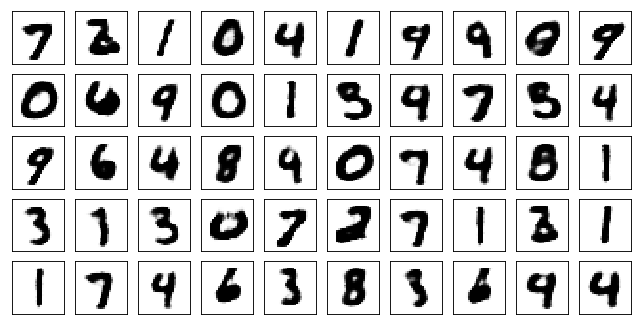

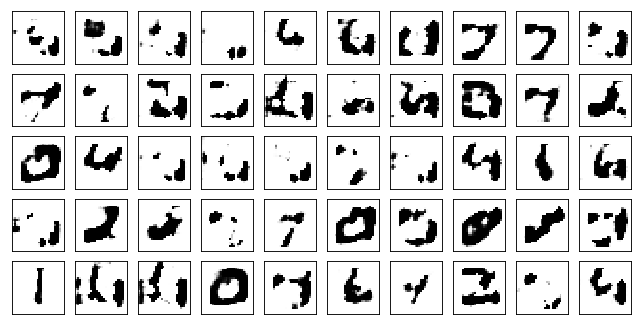

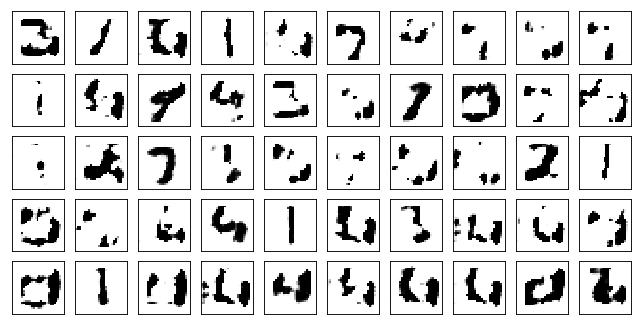

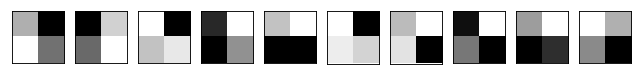

Model Adam Discr+bn+dp:


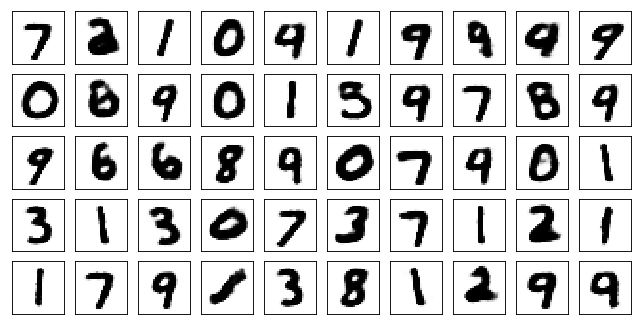

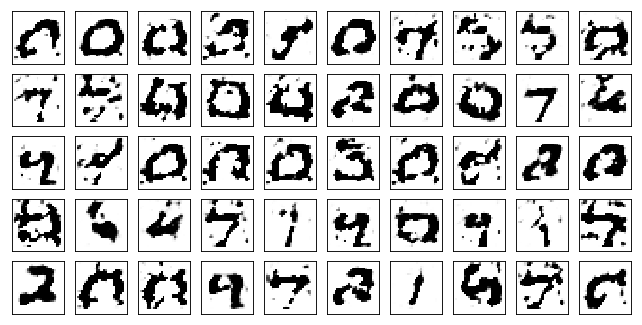

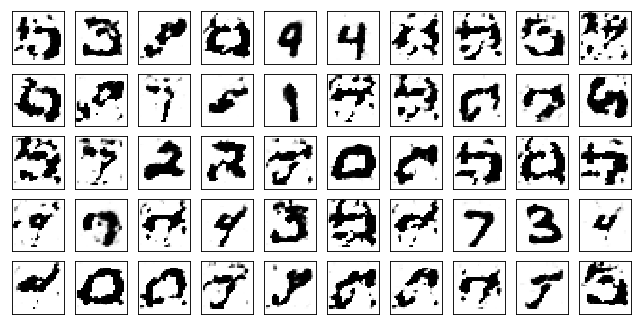

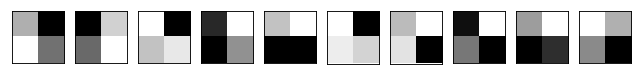

Test losses: 
Adam Discr+bn: 2.95505881 / 2.16280437 / 0.23822773 
Adam Discr+dp: 3.07611895 / 2.21170568 / 0.23886303 
Adam Discr+bn+dp: 3.04467273 / 2.20303655 / 0.23099823 

Train Epoch: 161 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.0285 D:0.0603 Adam Discr+dp: AE:1.0833 D:0.0548 Adam Discr+bn+dp: AE:1.0875 D:0.0889
Train Epoch: 161 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.0028 D:0.1409 Adam Discr+dp: AE:1.0978 D:0.0111 Adam Discr+bn+dp: AE:1.0647 D:0.1156
Train Epoch: 161 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:0.9657 D:0.0444 Adam Discr+dp: AE:1.0184 D:0.0214 Adam Discr+bn+dp: AE:1.0081 D:0.0855
Test losses: 
Adam Discr+bn: 2.95044756 / 2.11339235 / 0.23889802 
Adam Discr+dp: 3.07478213 / 2.22194552 / 0.23531489 
Adam Discr+bn+dp: 3.04016590 / 2.17886138 / 0.24315753 

Train Epoch: 162 [0/50000 (0%)]	Losses Adam Discr+bn: AE:0.9775 D:0.0830 Adam Discr+dp: AE:1.0606 D:0.0083 Adam Discr+bn+dp: AE:1.0228 D:0.0147
Train Epoch: 162 [25000/50000 (50%)]	Losses Adam Discr+bn: 

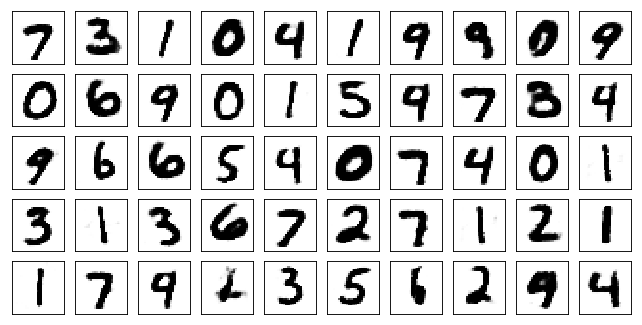

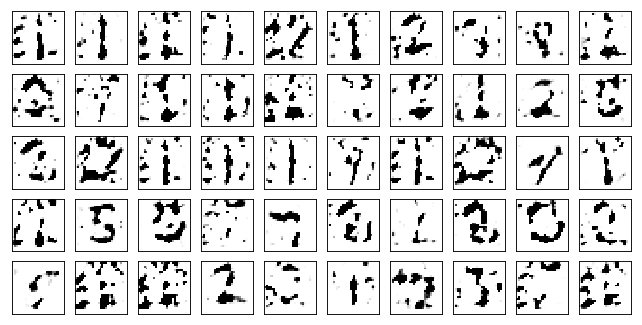

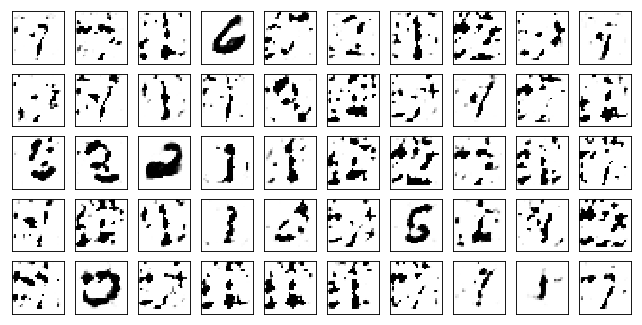

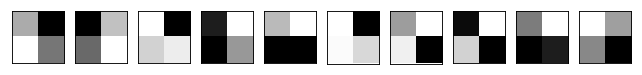

Model Adam Discr+dp:


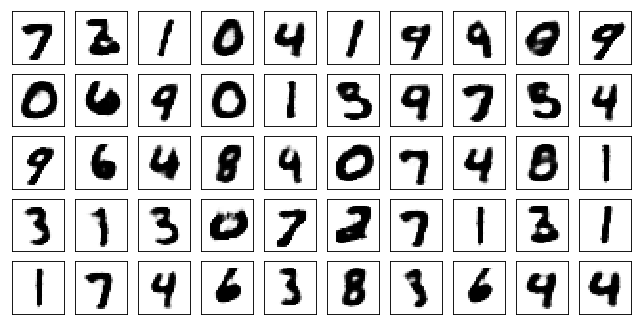

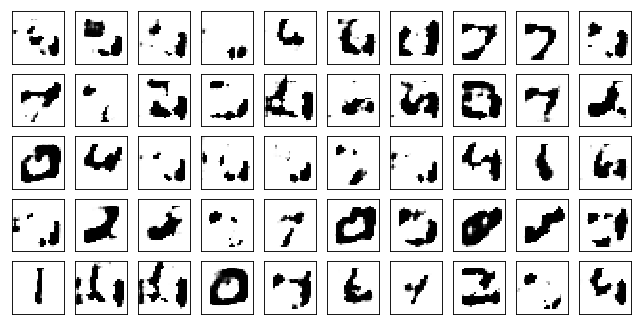

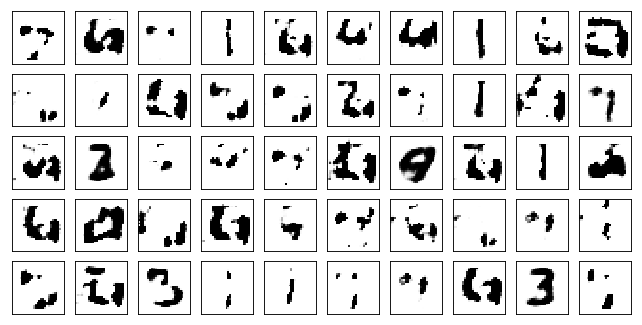

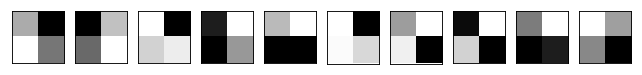

Model Adam Discr+bn+dp:


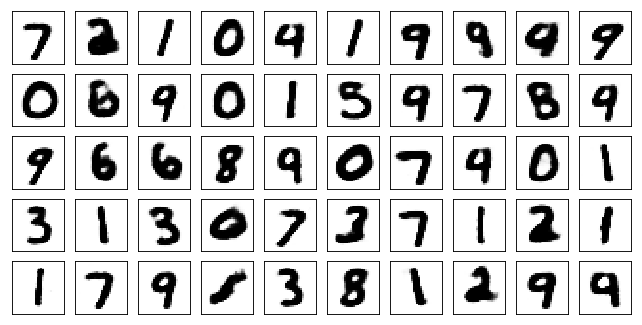

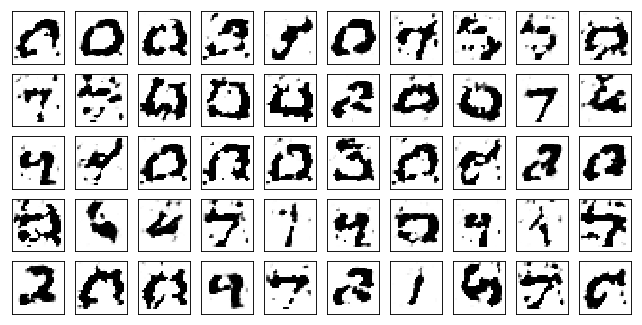

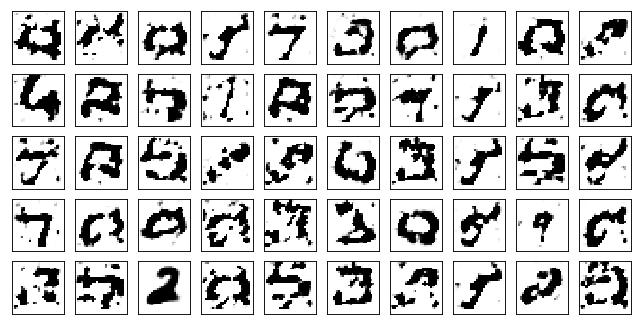

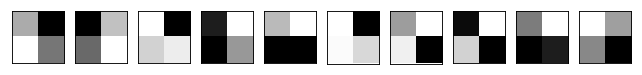

Test losses: 
Adam Discr+bn: 2.94972134 / 2.11182904 / 0.24010494 
Adam Discr+dp: 3.06735253 / 2.13583779 / 0.22908937 
Adam Discr+bn+dp: 3.04172206 / 2.19685221 / 0.24428907 

Train Epoch: 171 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.0251 D:0.0581 Adam Discr+dp: AE:1.0692 D:0.1198 Adam Discr+bn+dp: AE:1.0705 D:0.0510
Train Epoch: 171 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.0318 D:0.0181 Adam Discr+dp: AE:1.0501 D:0.0129 Adam Discr+bn+dp: AE:1.0296 D:0.1158
Train Epoch: 171 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:1.0224 D:0.0105 Adam Discr+dp: AE:1.0668 D:0.1003 Adam Discr+bn+dp: AE:1.0243 D:0.0197
Test losses: 
Adam Discr+bn: 2.94973755 / 2.13988304 / 0.24482797 
Adam Discr+dp: 3.06882215 / 2.12560248 / 0.22943754 
Adam Discr+bn+dp: 3.03596115 / 2.03719878 / 0.22339185 

Train Epoch: 172 [0/50000 (0%)]	Losses Adam Discr+bn: AE:0.9800 D:0.0093 Adam Discr+dp: AE:1.0362 D:0.1175 Adam Discr+bn+dp: AE:0.9869 D:0.0601
Train Epoch: 172 [25000/50000 (50%)]	Losses Adam Discr+bn: 

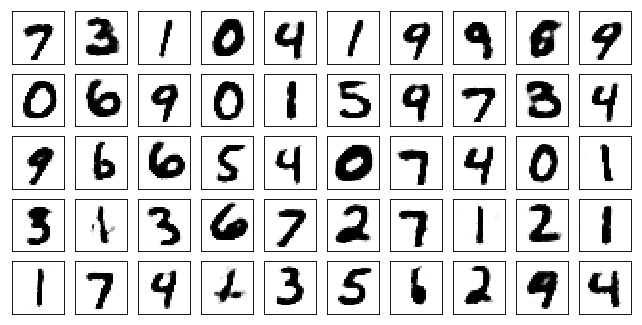

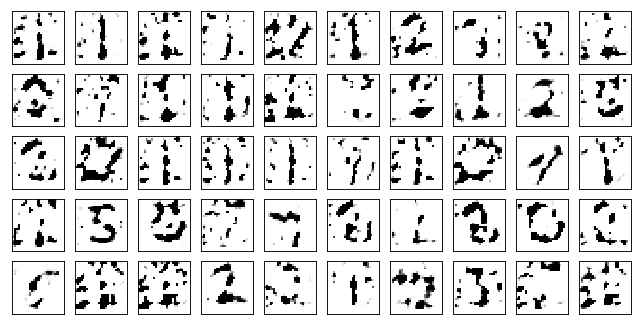

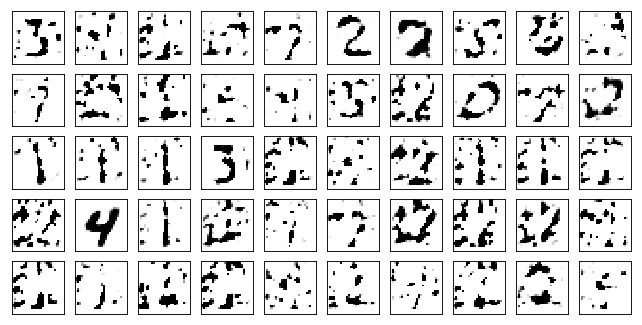

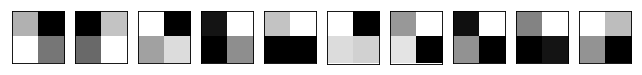

Model Adam Discr+dp:


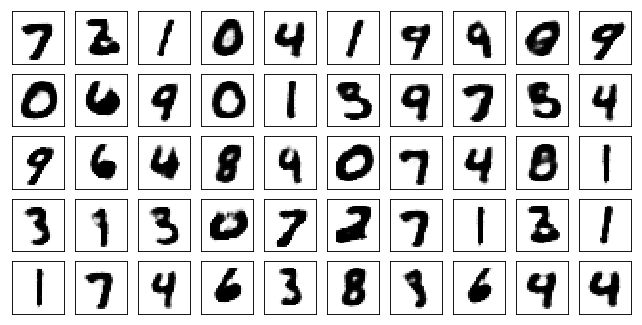

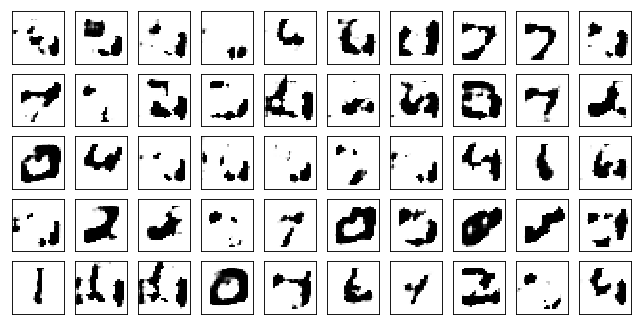

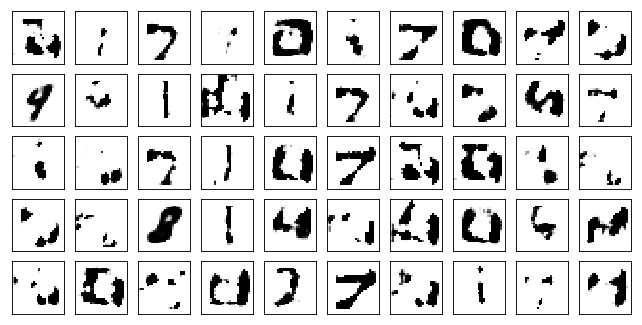

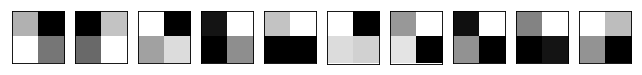

Model Adam Discr+bn+dp:


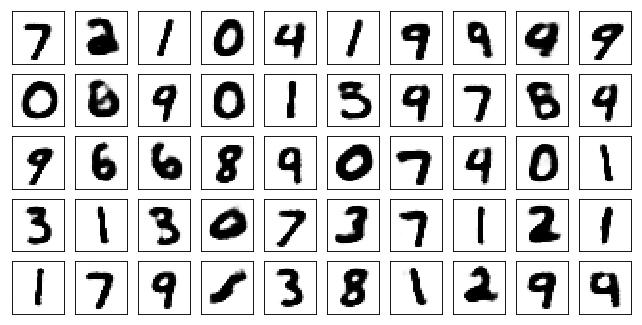

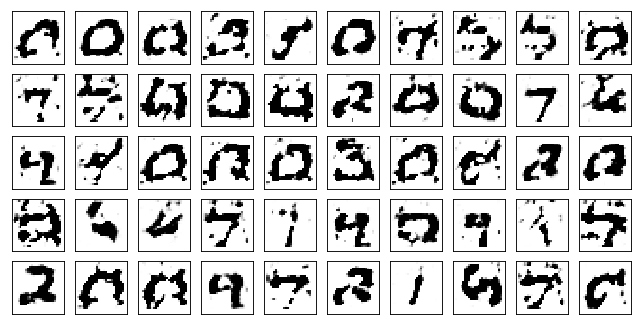

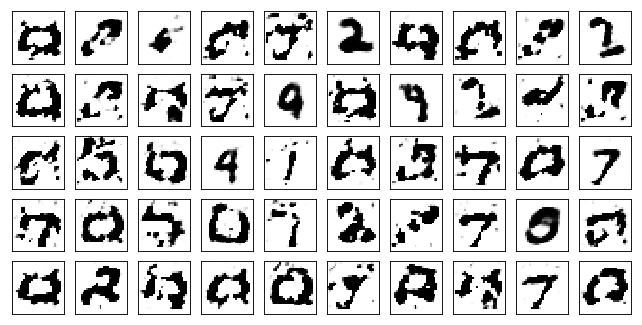

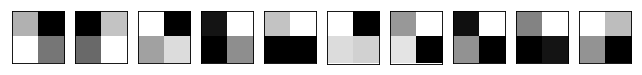

Test losses: 
Adam Discr+bn: 2.94027948 / 2.14305592 / 0.24808603 
Adam Discr+dp: 3.06452775 / 2.12881565 / 0.22157676 
Adam Discr+bn+dp: 3.03519440 / 2.13715577 / 0.22920972 

Train Epoch: 181 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.0077 D:0.0103 Adam Discr+dp: AE:1.0543 D:0.0985 Adam Discr+bn+dp: AE:1.0510 D:0.1101
Train Epoch: 181 [25000/50000 (50%)]	Losses Adam Discr+bn: AE:1.0151 D:0.0505 Adam Discr+dp: AE:1.0546 D:0.1299 Adam Discr+bn+dp: AE:1.0483 D:0.1314
Train Epoch: 181 [50000/50000 (100%)]	Losses Adam Discr+bn: AE:0.9905 D:0.0589 Adam Discr+dp: AE:1.0243 D:0.0352 Adam Discr+bn+dp: AE:1.0222 D:0.0174
Test losses: 
Adam Discr+bn: 2.94495869 / 2.16055846 / 0.24293948 
Adam Discr+dp: 3.06505847 / 2.07929659 / 0.22203302 
Adam Discr+bn+dp: 3.03410149 / 2.24543214 / 0.22618116 

Train Epoch: 182 [0/50000 (0%)]	Losses Adam Discr+bn: AE:1.0396 D:0.0538 Adam Discr+dp: AE:1.0303 D:0.0227 Adam Discr+bn+dp: AE:1.0776 D:0.0866
Train Epoch: 182 [25000/50000 (50%)]	Losses Adam Discr+bn: 

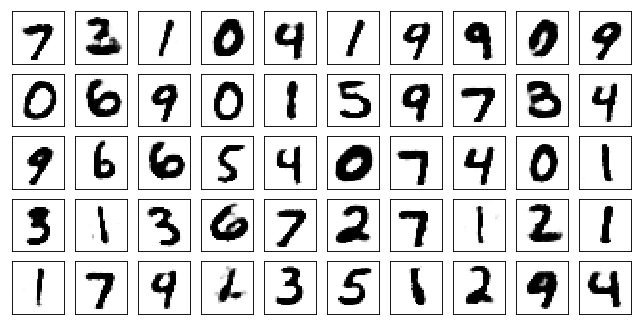

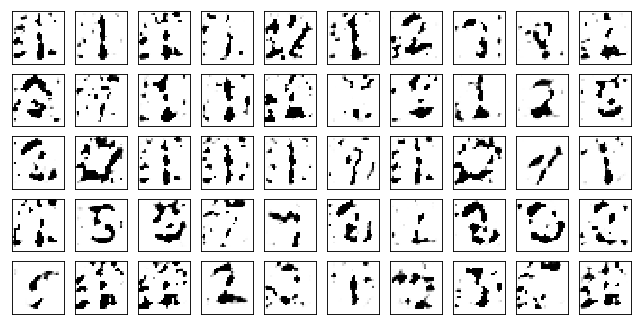

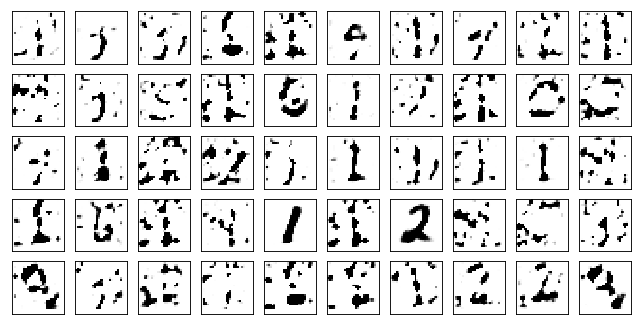

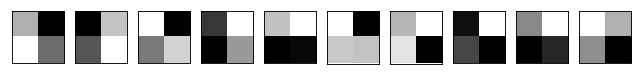

In [ ]:
for epoch in range(1, train_epoch):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, epoch, 10, test_log)

In [ ]:
for model in models.values():
    model.eval()
test(models, valid_loader, 1, 1, test_log)

In [ ]:
torch.save(models['Adam Discr+bn'], './adam_ds_bn_l4_1')
torch.save(models['Adam Discr+dp'], './adam_ds_dp_l4_1')
torch.save(models['Adam Discr+bn+dp'], './adam_ds_bndp_l4_1')

### Вывод результатов

In [ ]:
model = torch.load('./adam_ds_bndp_l4_1')

In [ ]:
data, _ = next(iter(test_loader))
output = model(data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).cpu().data.numpy()
with torch.no_grad():
    encoded = model.encode(data)
    enc_to_lot = encoded.view(-1, 1, 2, 2).clamp(0, 1).cpu().data.numpy()
    print ('enc=', encoded.shape)


In [ ]:
plot_mnist(data.data.clamp(0, 1).cpu().numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_latent(enc_to_lot, (5, 10))

In [ ]:
def show_generated_samples():
    pred_z = torch.randn((50, 4)).to(device)
       
    pred_gen = model.decode(pred_z)
    generated = pred_gen.view(-1, 1, 28, 28).clamp(0, 1).cpu().data.numpy()  
    plot_mnist(generated, (5, 10))

In [ ]:
show_generated_samples()

In [ ]:
show_generated_samples()